In [1]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils

In [3]:
# Перевірка доступності GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")

In [4]:
# Версії встановлених бібліотек
print(f"Обчислювальне середовище: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")

Обчислювальне середовище: cuda
PyTorch version: 2.4.0+cu121
torchvision version: 0.19.0+cu121
numpy version: 1.26.4
matplotlib version: 3.10.0


In [5]:
# Трансформація для зменшення роздільної здатності, додавання шуму та нормалізації
transform = transforms.Compose(
    [
        transforms.Resize(14),  # Зменшення роздільної здатності до 14x14
        transforms.Resize(28),  # Повернення до 28x28
        transforms.ToTensor(),  # Перетворення в тензор
        transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x)),  # Додавання шуму
        transforms.Normalize((0.5,), (0.5,)),  # Нормалізація до діапазону [-1, 1]
    ]
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 3781201.31it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 138371.53it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1303589.20it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1492520.27it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Shape of example images: torch.Size([64, 1, 28, 28])
Shape of example labels: torch.Size([64])


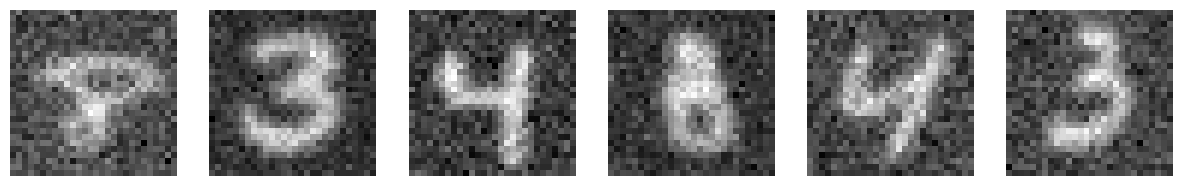

In [6]:
# Завантаження даних MNIST
train_dataset = MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = MNIST(root="./data", train=False, download=True, transform=transform)

# Створення DataLoader для батчів
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Перевірка розмірів даних та приклад зображення
example_batch = next(iter(train_loader))
example_images, example_labels = example_batch

print(f"Shape of example images: {example_images.shape}")
print(f"Shape of example labels: {example_labels.shape}")

# Відображення кількох зображень з шумом
fig, axes = plt.subplots(1, 6, figsize=(15, 4))
for i in range(6):
    axes[i].imshow(example_images[i][0].cpu().numpy(), cmap="gray")
    axes[i].axis("off")
plt.show()

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.latent_to_feature = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, kernel_size=7, stride=1, padding=0),
            nn.ReLU(inplace=True),
        )
        self.main = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),  # Нормалізація до [-1, 1]
        )

    def forward(self, x):
        x = self.latent_to_feature(x)
        return self.main(x)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.main(x)

In [9]:
# Функції втрат
adversarial_loss = nn.BCELoss()  # Для дискримінатора та генератора (adversarial loss)
l1_loss = nn.L1Loss()  # Для генератора (реконструкція зображень)

# Ініціалізація генератора та дискримінатора
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Оптимізатори
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

print("Функції втрат та оптимізатори успішно ініціалізовані.")

Функції втрат та оптимізатори успішно ініціалізовані.


In [10]:
# Гіперпараметри
num_epochs = 50
batch_size = 64
latent_dim = 100  # Розмір вектора шуму

# Реальний та згенерований лейбли
real_label = 1.0
fake_label = 0.0

torch.autograd.set_detect_anomaly(True)

Epoch [1/50] Batch 0/938 Loss D: 1.5401, Loss G: 2.6993
Epoch [1/50] Batch 100/938 Loss D: 0.7832, Loss G: 4.9603
Epoch [1/50] Batch 200/938 Loss D: 0.3378, Loss G: 2.1834
Epoch [1/50] Batch 300/938 Loss D: 0.2190, Loss G: 3.0128
Epoch [1/50] Batch 400/938 Loss D: 0.8927, Loss G: 1.7070
Epoch [1/50] Batch 500/938 Loss D: 1.5534, Loss G: 5.5967
Epoch [1/50] Batch 600/938 Loss D: 0.4700, Loss G: 2.1024
Epoch [1/50] Batch 700/938 Loss D: 0.4617, Loss G: 2.9544
Epoch [1/50] Batch 800/938 Loss D: 0.5077, Loss G: 1.4580
Epoch [1/50] Batch 900/938 Loss D: 0.6470, Loss G: 1.2649


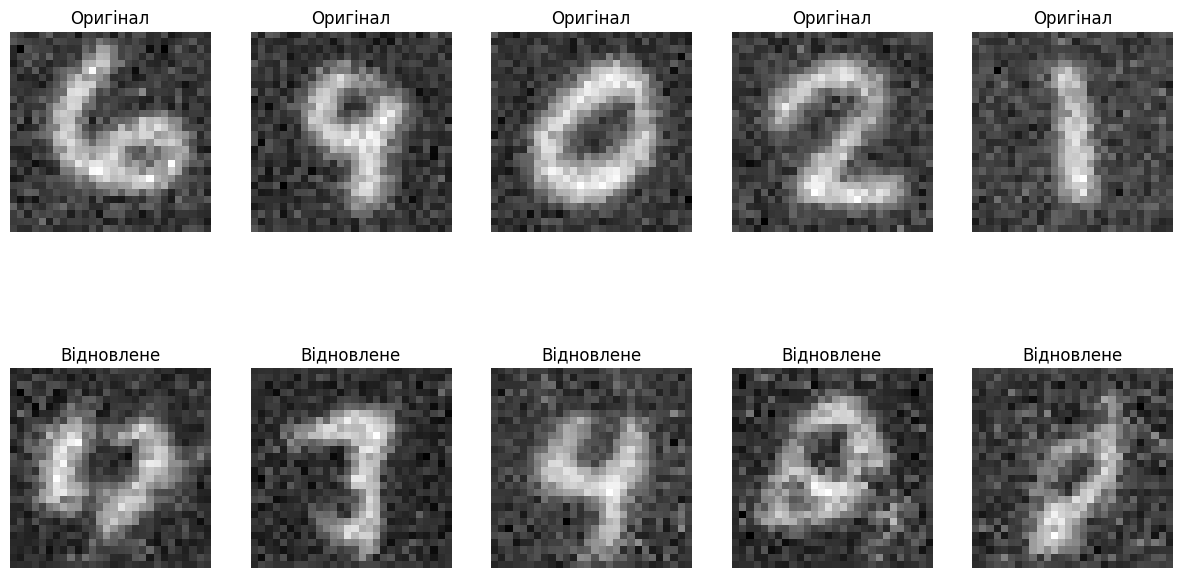

Epoch [2/50] Batch 0/938 Loss D: 1.0742, Loss G: 2.3296
Epoch [2/50] Batch 100/938 Loss D: 0.7432, Loss G: 2.6393
Epoch [2/50] Batch 200/938 Loss D: 0.9729, Loss G: 3.0228
Epoch [2/50] Batch 300/938 Loss D: 0.8166, Loss G: 1.1513
Epoch [2/50] Batch 400/938 Loss D: 0.7718, Loss G: 1.8101
Epoch [2/50] Batch 500/938 Loss D: 0.8677, Loss G: 1.0733
Epoch [2/50] Batch 600/938 Loss D: 0.8510, Loss G: 1.1636
Epoch [2/50] Batch 700/938 Loss D: 0.7916, Loss G: 1.4375
Epoch [2/50] Batch 800/938 Loss D: 1.0003, Loss G: 1.8934
Epoch [2/50] Batch 900/938 Loss D: 0.8528, Loss G: 1.2192


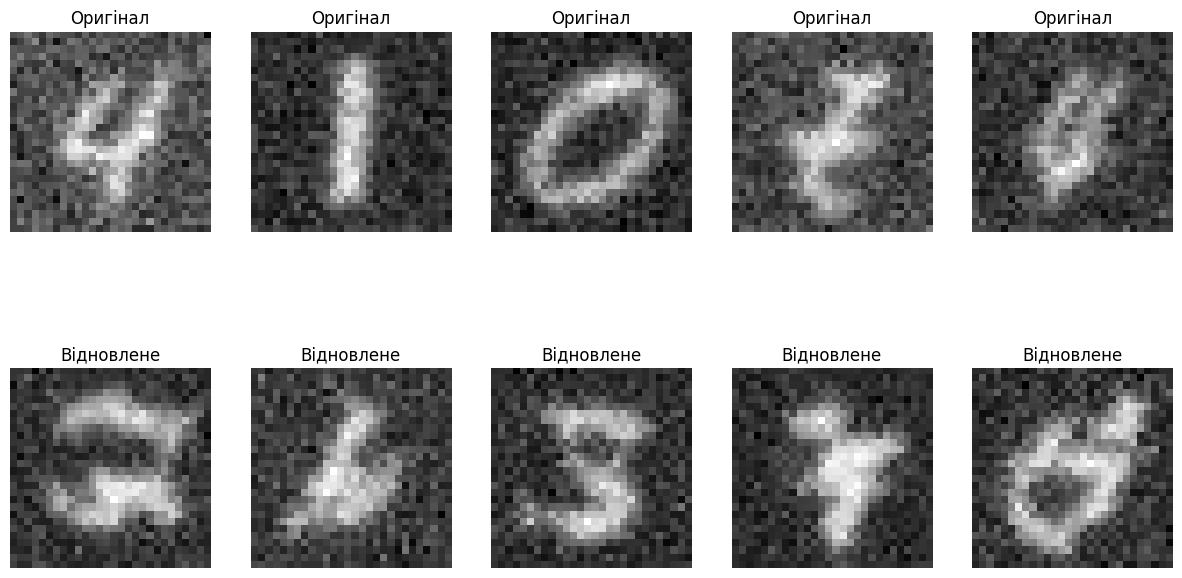

Epoch [3/50] Batch 0/938 Loss D: 0.9286, Loss G: 1.1007
Epoch [3/50] Batch 100/938 Loss D: 0.7105, Loss G: 1.5778
Epoch [3/50] Batch 200/938 Loss D: 0.8051, Loss G: 1.7643
Epoch [3/50] Batch 300/938 Loss D: 0.8062, Loss G: 1.2917
Epoch [3/50] Batch 400/938 Loss D: 0.9201, Loss G: 1.5232
Epoch [3/50] Batch 500/938 Loss D: 0.8517, Loss G: 1.3004
Epoch [3/50] Batch 600/938 Loss D: 0.8880, Loss G: 1.3074
Epoch [3/50] Batch 700/938 Loss D: 0.8357, Loss G: 1.3306
Epoch [3/50] Batch 800/938 Loss D: 1.0435, Loss G: 0.6747
Epoch [3/50] Batch 900/938 Loss D: 0.8756, Loss G: 2.2393


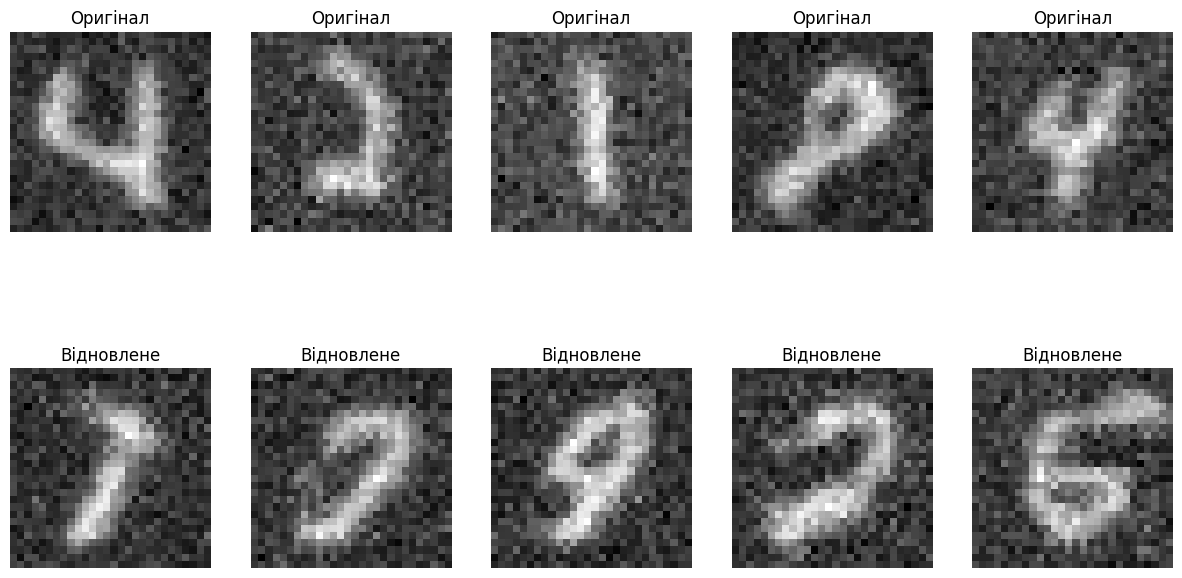

Epoch [4/50] Batch 0/938 Loss D: 0.9639, Loss G: 2.2338
Epoch [4/50] Batch 100/938 Loss D: 1.0537, Loss G: 1.7317
Epoch [4/50] Batch 200/938 Loss D: 0.7688, Loss G: 1.7914
Epoch [4/50] Batch 300/938 Loss D: 0.8609, Loss G: 1.4605
Epoch [4/50] Batch 400/938 Loss D: 0.8315, Loss G: 1.8777
Epoch [4/50] Batch 500/938 Loss D: 0.8795, Loss G: 1.2897
Epoch [4/50] Batch 600/938 Loss D: 1.1137, Loss G: 1.0955
Epoch [4/50] Batch 700/938 Loss D: 0.8235, Loss G: 1.8215
Epoch [4/50] Batch 800/938 Loss D: 0.7747, Loss G: 1.7736
Epoch [4/50] Batch 900/938 Loss D: 0.8380, Loss G: 1.6578


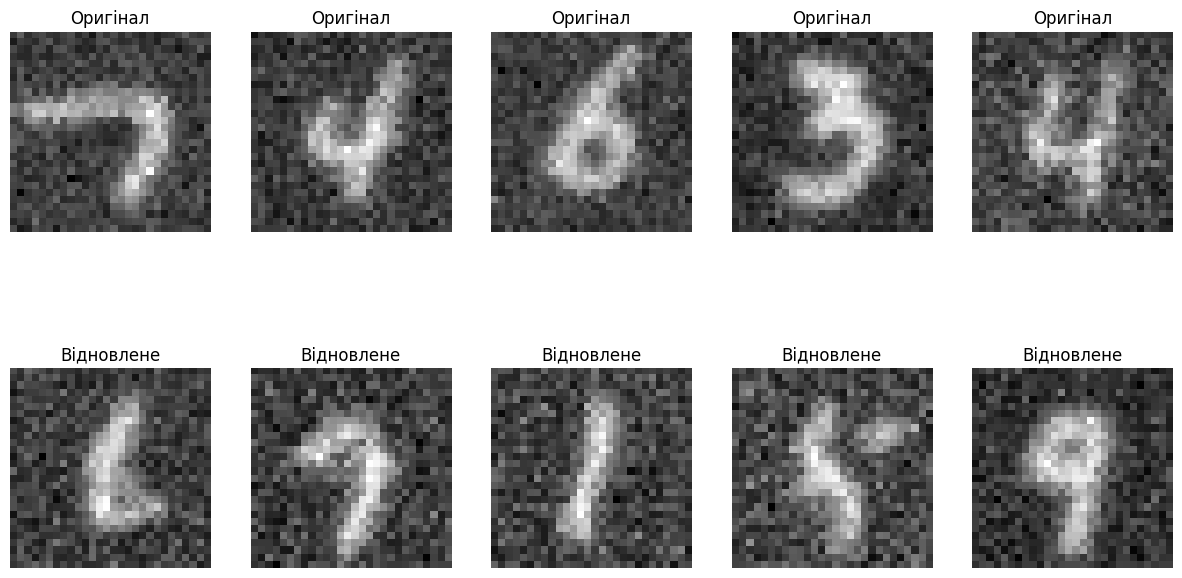

Epoch [5/50] Batch 0/938 Loss D: 1.2023, Loss G: 0.9208
Epoch [5/50] Batch 100/938 Loss D: 0.9429, Loss G: 1.2857
Epoch [5/50] Batch 200/938 Loss D: 1.1057, Loss G: 0.8690
Epoch [5/50] Batch 300/938 Loss D: 0.8525, Loss G: 1.4689
Epoch [5/50] Batch 400/938 Loss D: 1.0795, Loss G: 0.8618
Epoch [5/50] Batch 500/938 Loss D: 0.8561, Loss G: 1.7845
Epoch [5/50] Batch 600/938 Loss D: 1.1951, Loss G: 1.1561
Epoch [5/50] Batch 700/938 Loss D: 1.0874, Loss G: 0.7728
Epoch [5/50] Batch 800/938 Loss D: 0.8441, Loss G: 1.6428
Epoch [5/50] Batch 900/938 Loss D: 0.8932, Loss G: 1.2169


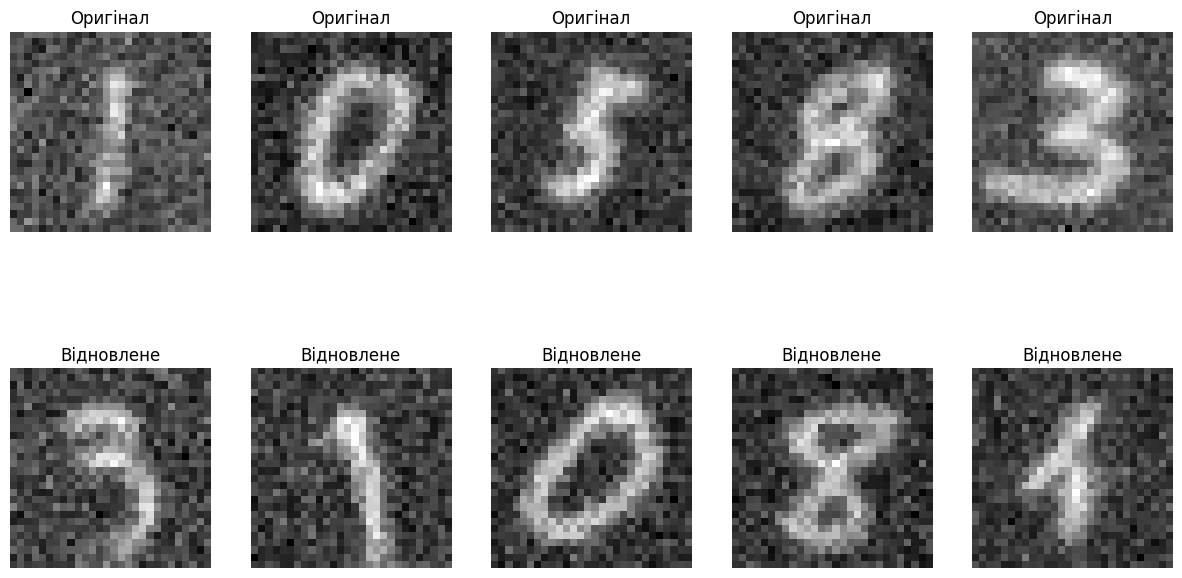

Epoch [6/50] Batch 0/938 Loss D: 0.7576, Loss G: 2.4184
Epoch [6/50] Batch 100/938 Loss D: 0.9579, Loss G: 0.9774
Epoch [6/50] Batch 200/938 Loss D: 1.2286, Loss G: 0.9554
Epoch [6/50] Batch 300/938 Loss D: 1.0246, Loss G: 0.7604
Epoch [6/50] Batch 400/938 Loss D: 0.7681, Loss G: 1.6080
Epoch [6/50] Batch 500/938 Loss D: 1.0137, Loss G: 1.7827
Epoch [6/50] Batch 600/938 Loss D: 1.0913, Loss G: 1.4383
Epoch [6/50] Batch 700/938 Loss D: 0.9882, Loss G: 1.9066
Epoch [6/50] Batch 800/938 Loss D: 0.9716, Loss G: 1.3041
Epoch [6/50] Batch 900/938 Loss D: 0.9379, Loss G: 1.4839


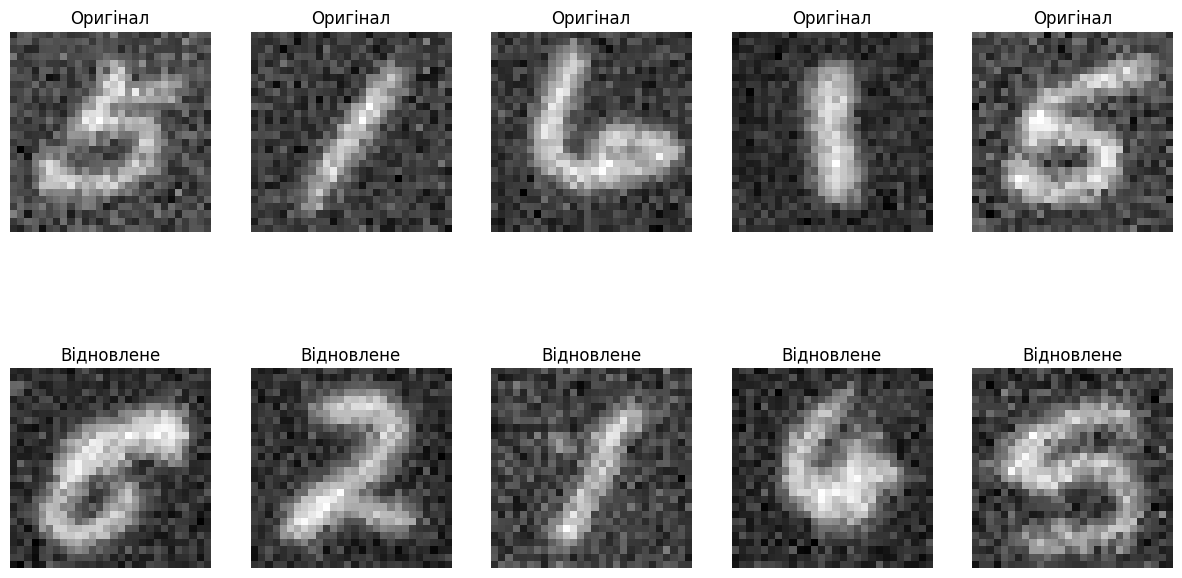

Epoch [7/50] Batch 0/938 Loss D: 1.0796, Loss G: 2.0718
Epoch [7/50] Batch 100/938 Loss D: 1.0527, Loss G: 1.4014
Epoch [7/50] Batch 200/938 Loss D: 0.9827, Loss G: 1.9429
Epoch [7/50] Batch 300/938 Loss D: 1.1867, Loss G: 2.7488
Epoch [7/50] Batch 400/938 Loss D: 1.1919, Loss G: 1.3942
Epoch [7/50] Batch 500/938 Loss D: 0.8397, Loss G: 1.7408
Epoch [7/50] Batch 600/938 Loss D: 1.1290, Loss G: 1.3355
Epoch [7/50] Batch 700/938 Loss D: 1.0548, Loss G: 2.0257
Epoch [7/50] Batch 800/938 Loss D: 0.9252, Loss G: 1.3245
Epoch [7/50] Batch 900/938 Loss D: 1.1096, Loss G: 1.5419


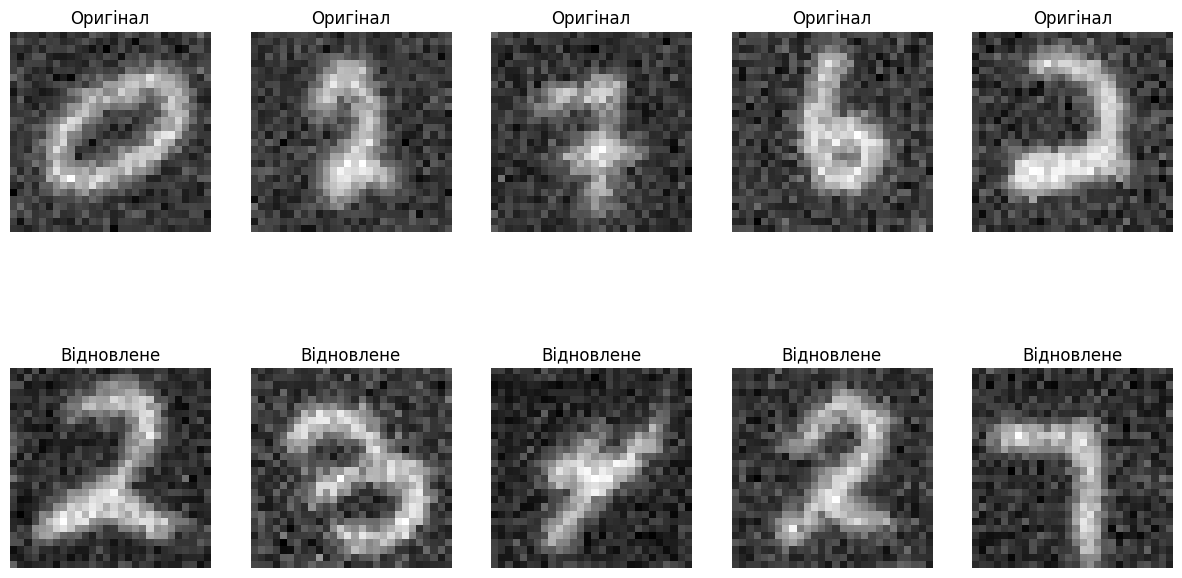

Epoch [8/50] Batch 0/938 Loss D: 0.9372, Loss G: 0.9925
Epoch [8/50] Batch 100/938 Loss D: 1.1215, Loss G: 1.2863
Epoch [8/50] Batch 200/938 Loss D: 0.8284, Loss G: 1.4188
Epoch [8/50] Batch 300/938 Loss D: 0.9791, Loss G: 1.4010
Epoch [8/50] Batch 400/938 Loss D: 0.7630, Loss G: 1.3451
Epoch [8/50] Batch 500/938 Loss D: 1.2245, Loss G: 1.2303
Epoch [8/50] Batch 600/938 Loss D: 1.0797, Loss G: 1.0428
Epoch [8/50] Batch 700/938 Loss D: 0.9294, Loss G: 1.2717
Epoch [8/50] Batch 800/938 Loss D: 1.2696, Loss G: 1.6599
Epoch [8/50] Batch 900/938 Loss D: 0.9337, Loss G: 1.9730


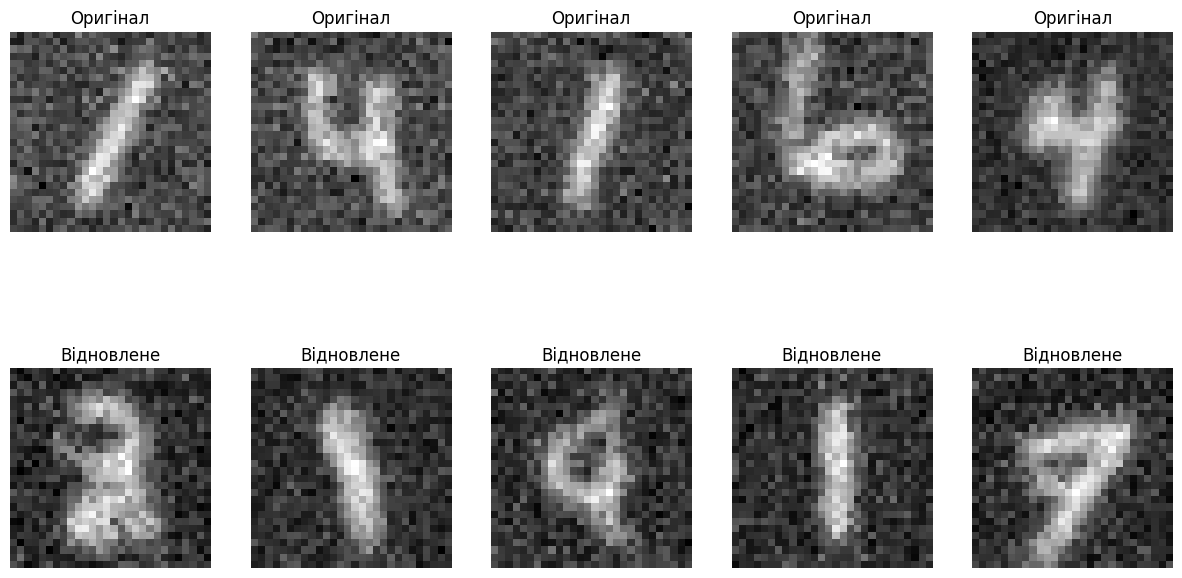

Epoch [9/50] Batch 0/938 Loss D: 0.8888, Loss G: 1.1486
Epoch [9/50] Batch 100/938 Loss D: 1.0216, Loss G: 1.1158
Epoch [9/50] Batch 200/938 Loss D: 0.9012, Loss G: 1.1876
Epoch [9/50] Batch 300/938 Loss D: 1.0828, Loss G: 1.5532
Epoch [9/50] Batch 400/938 Loss D: 0.9372, Loss G: 1.6001
Epoch [9/50] Batch 500/938 Loss D: 1.1931, Loss G: 0.9683
Epoch [9/50] Batch 600/938 Loss D: 1.0210, Loss G: 1.5453
Epoch [9/50] Batch 700/938 Loss D: 0.9135, Loss G: 1.3458
Epoch [9/50] Batch 800/938 Loss D: 1.0968, Loss G: 1.2304
Epoch [9/50] Batch 900/938 Loss D: 0.9715, Loss G: 1.6471


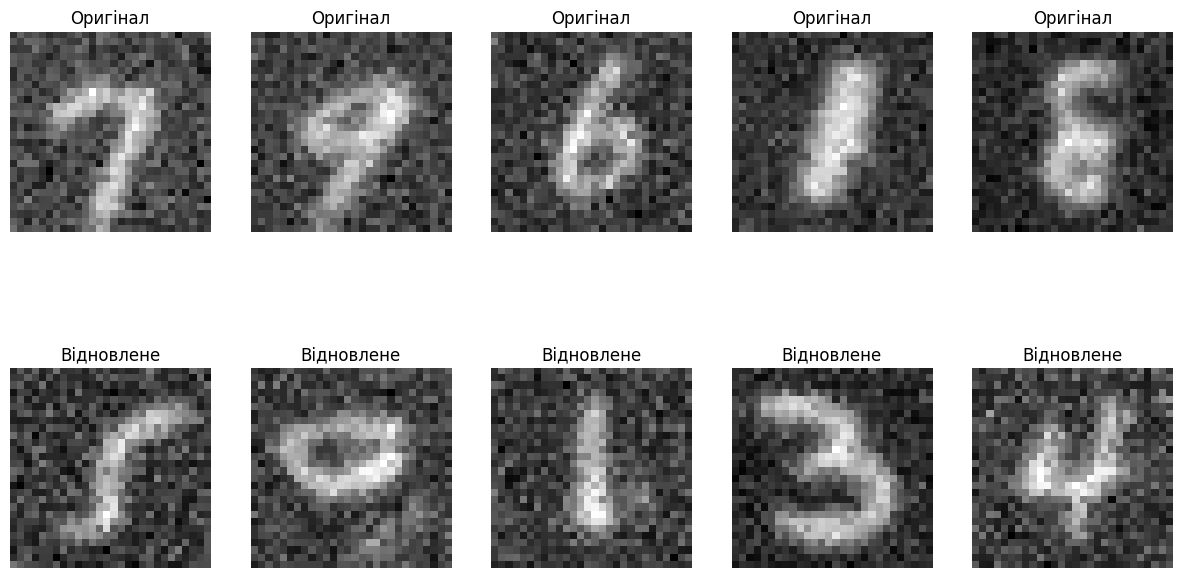

Epoch [10/50] Batch 0/938 Loss D: 1.2068, Loss G: 1.4261
Epoch [10/50] Batch 100/938 Loss D: 1.1947, Loss G: 1.9187
Epoch [10/50] Batch 200/938 Loss D: 0.9409, Loss G: 1.3737
Epoch [10/50] Batch 300/938 Loss D: 0.9708, Loss G: 1.4497
Epoch [10/50] Batch 400/938 Loss D: 1.0973, Loss G: 1.5766
Epoch [10/50] Batch 500/938 Loss D: 1.1635, Loss G: 1.1568
Epoch [10/50] Batch 600/938 Loss D: 1.2936, Loss G: 1.0359
Epoch [10/50] Batch 700/938 Loss D: 1.2138, Loss G: 0.8317
Epoch [10/50] Batch 800/938 Loss D: 1.0174, Loss G: 1.4502
Epoch [10/50] Batch 900/938 Loss D: 1.0627, Loss G: 1.7216


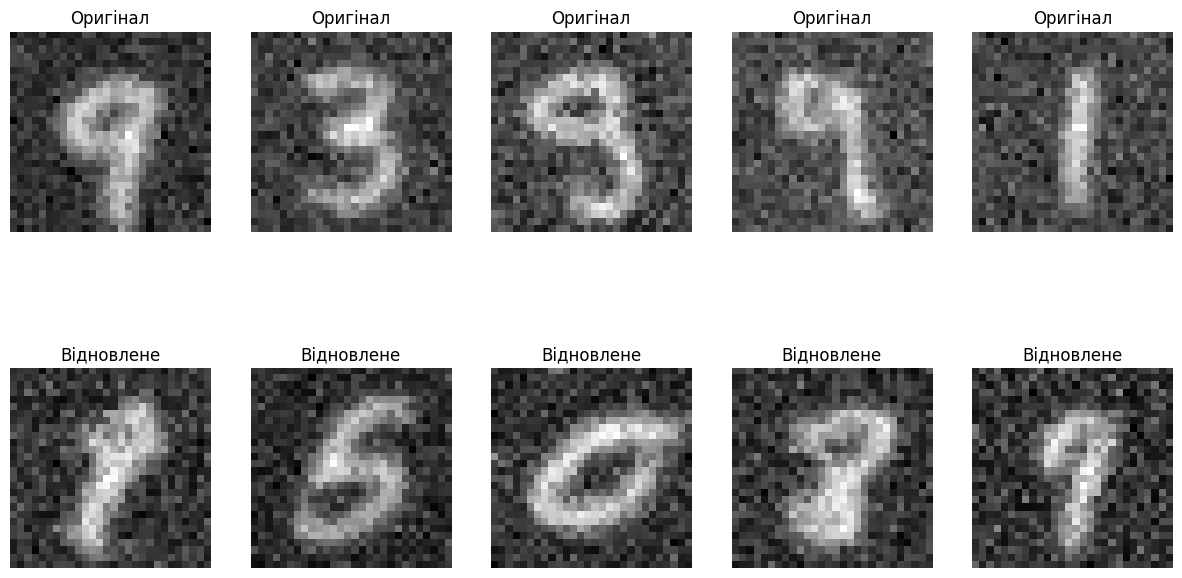

Epoch [11/50] Batch 0/938 Loss D: 0.9600, Loss G: 2.0226
Epoch [11/50] Batch 100/938 Loss D: 1.1841, Loss G: 1.3568
Epoch [11/50] Batch 200/938 Loss D: 0.9925, Loss G: 1.8497
Epoch [11/50] Batch 300/938 Loss D: 1.0262, Loss G: 1.5391
Epoch [11/50] Batch 400/938 Loss D: 0.8492, Loss G: 1.6663
Epoch [11/50] Batch 500/938 Loss D: 1.0836, Loss G: 1.1647
Epoch [11/50] Batch 600/938 Loss D: 0.9543, Loss G: 1.6201
Epoch [11/50] Batch 700/938 Loss D: 1.0906, Loss G: 1.0134
Epoch [11/50] Batch 800/938 Loss D: 0.8287, Loss G: 1.6234
Epoch [11/50] Batch 900/938 Loss D: 1.0870, Loss G: 1.6539


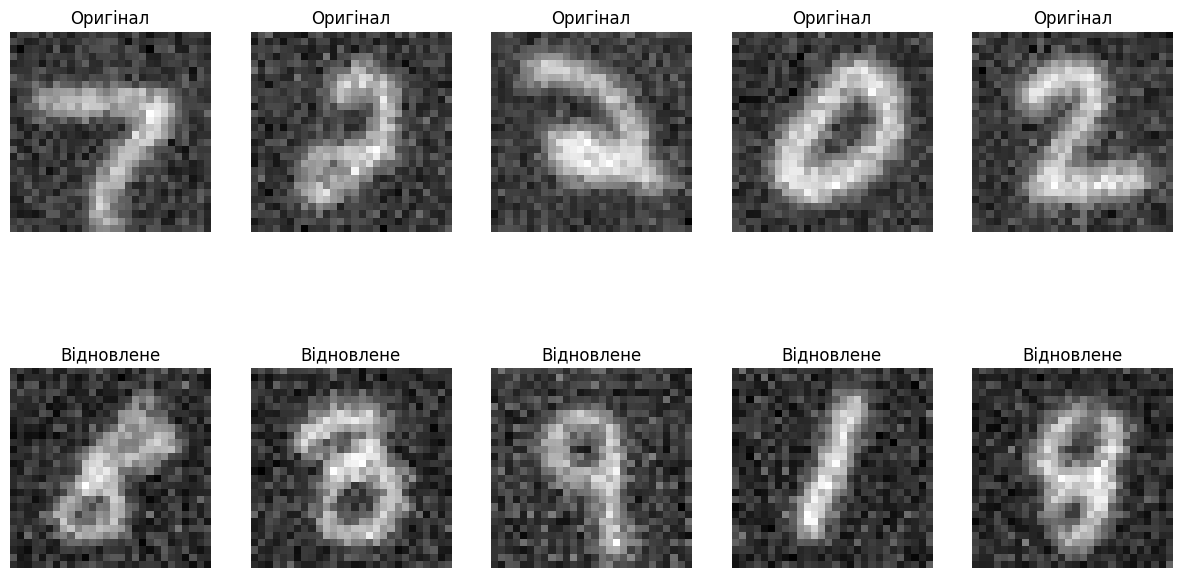

Epoch [12/50] Batch 0/938 Loss D: 1.0191, Loss G: 1.4403
Epoch [12/50] Batch 100/938 Loss D: 0.9792, Loss G: 1.1742
Epoch [12/50] Batch 200/938 Loss D: 1.1648, Loss G: 1.0417
Epoch [12/50] Batch 300/938 Loss D: 0.9925, Loss G: 1.4512
Epoch [12/50] Batch 400/938 Loss D: 0.8787, Loss G: 1.6046
Epoch [12/50] Batch 500/938 Loss D: 1.1661, Loss G: 1.3096
Epoch [12/50] Batch 600/938 Loss D: 1.3429, Loss G: 2.1095
Epoch [12/50] Batch 700/938 Loss D: 1.3106, Loss G: 0.7044
Epoch [12/50] Batch 800/938 Loss D: 1.2471, Loss G: 0.8960
Epoch [12/50] Batch 900/938 Loss D: 0.8632, Loss G: 1.6509


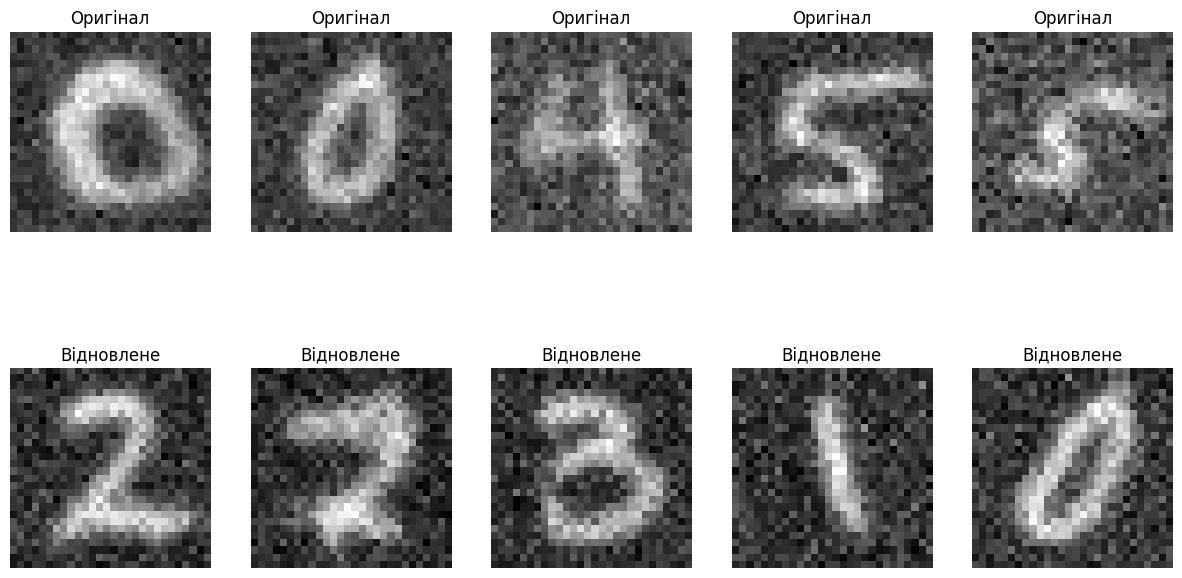

Epoch [13/50] Batch 0/938 Loss D: 1.1623, Loss G: 1.3738
Epoch [13/50] Batch 100/938 Loss D: 1.1041, Loss G: 1.2020
Epoch [13/50] Batch 200/938 Loss D: 1.1421, Loss G: 1.3581
Epoch [13/50] Batch 300/938 Loss D: 1.0610, Loss G: 1.0874
Epoch [13/50] Batch 400/938 Loss D: 1.1907, Loss G: 1.2881
Epoch [13/50] Batch 500/938 Loss D: 1.1322, Loss G: 1.3943
Epoch [13/50] Batch 600/938 Loss D: 0.9991, Loss G: 1.4038
Epoch [13/50] Batch 700/938 Loss D: 1.0379, Loss G: 1.3541
Epoch [13/50] Batch 800/938 Loss D: 1.1486, Loss G: 1.0605
Epoch [13/50] Batch 900/938 Loss D: 1.1282, Loss G: 1.3647


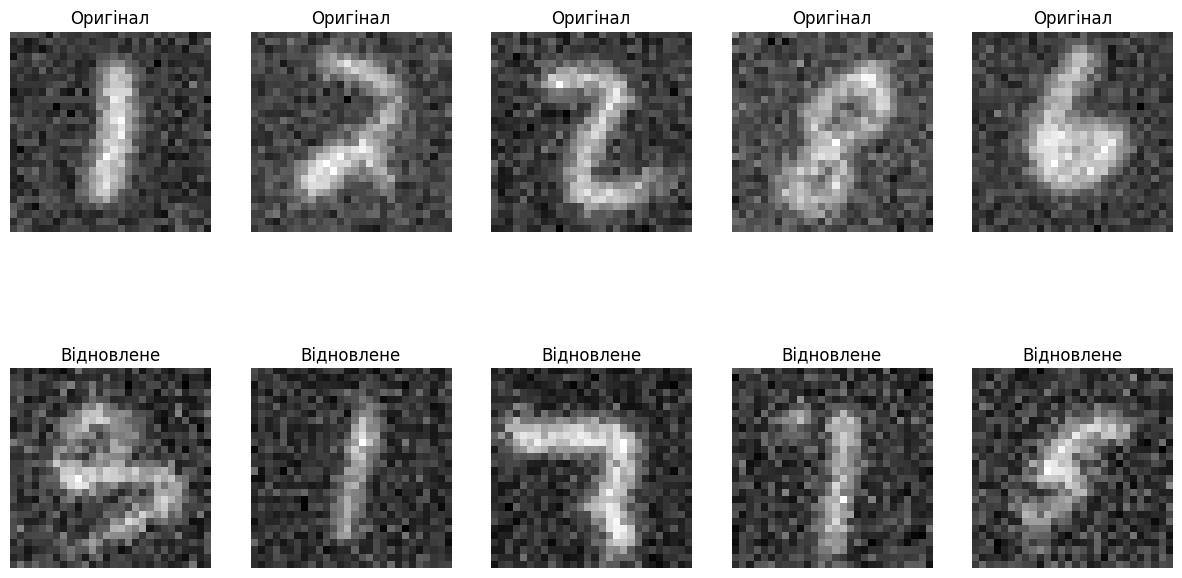

Epoch [14/50] Batch 0/938 Loss D: 0.9338, Loss G: 1.7680
Epoch [14/50] Batch 100/938 Loss D: 1.0769, Loss G: 0.9837
Epoch [14/50] Batch 200/938 Loss D: 1.0022, Loss G: 1.0862
Epoch [14/50] Batch 300/938 Loss D: 1.0825, Loss G: 1.3830
Epoch [14/50] Batch 400/938 Loss D: 1.1767, Loss G: 1.1978
Epoch [14/50] Batch 500/938 Loss D: 1.0187, Loss G: 1.0795
Epoch [14/50] Batch 600/938 Loss D: 1.0036, Loss G: 1.2514
Epoch [14/50] Batch 700/938 Loss D: 1.1037, Loss G: 1.2494
Epoch [14/50] Batch 800/938 Loss D: 1.0887, Loss G: 1.2975
Epoch [14/50] Batch 900/938 Loss D: 1.3035, Loss G: 2.2500


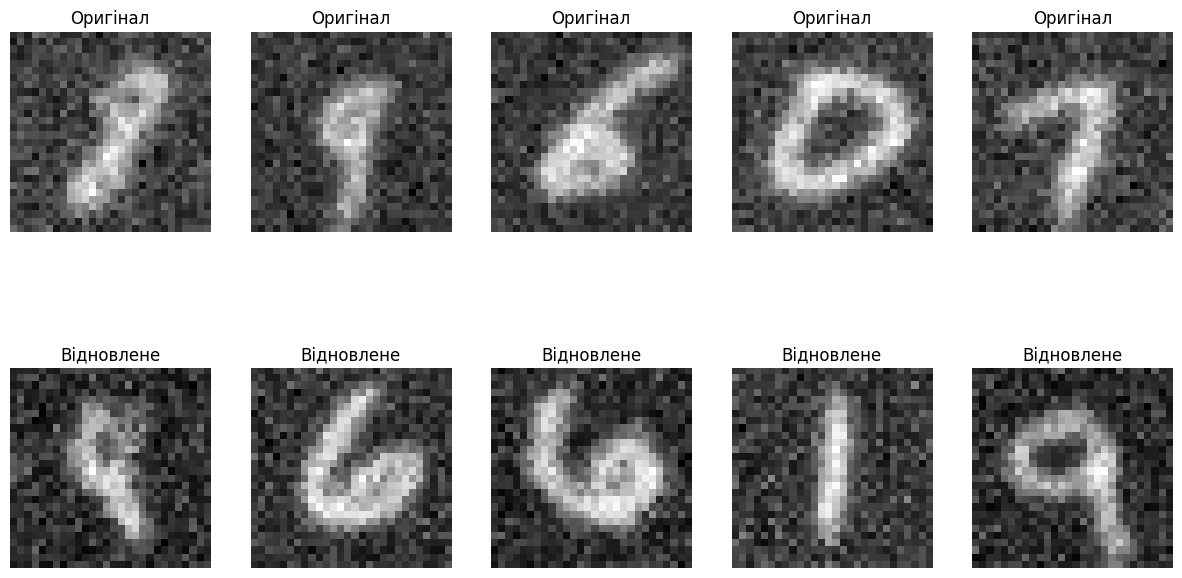

Epoch [15/50] Batch 0/938 Loss D: 1.0577, Loss G: 1.3603
Epoch [15/50] Batch 100/938 Loss D: 1.0594, Loss G: 2.1751
Epoch [15/50] Batch 200/938 Loss D: 1.0083, Loss G: 1.4208
Epoch [15/50] Batch 300/938 Loss D: 1.0457, Loss G: 1.3679
Epoch [15/50] Batch 400/938 Loss D: 1.0695, Loss G: 1.1062
Epoch [15/50] Batch 500/938 Loss D: 1.0873, Loss G: 1.4318
Epoch [15/50] Batch 600/938 Loss D: 1.1190, Loss G: 1.1969
Epoch [15/50] Batch 700/938 Loss D: 1.1361, Loss G: 1.6279
Epoch [15/50] Batch 800/938 Loss D: 1.0855, Loss G: 0.6883
Epoch [15/50] Batch 900/938 Loss D: 1.2293, Loss G: 1.2609


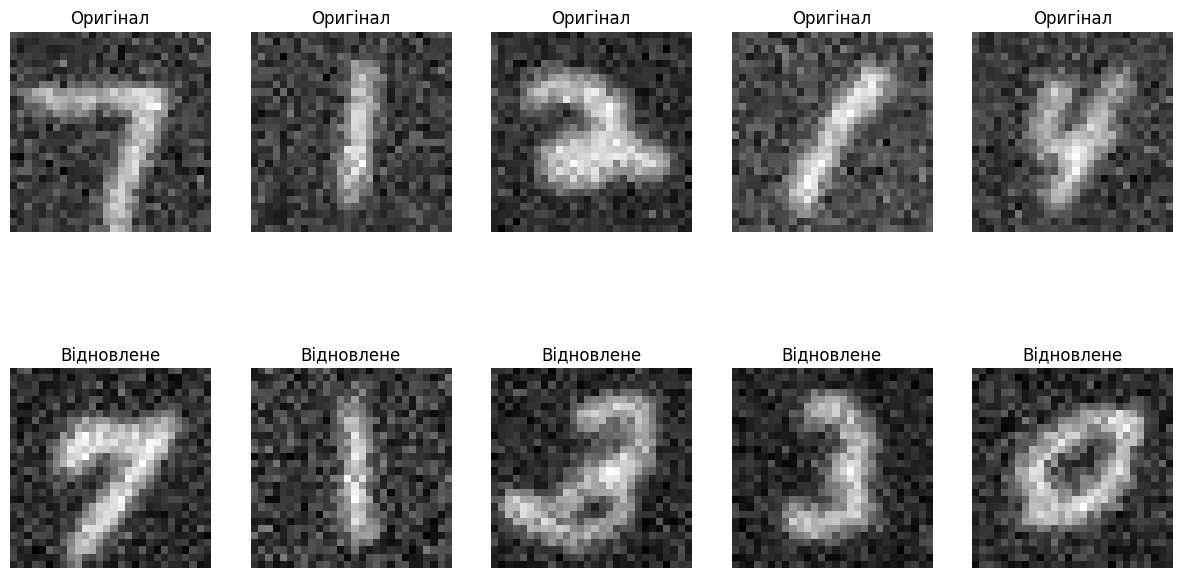

Epoch [16/50] Batch 0/938 Loss D: 0.9549, Loss G: 1.1791
Epoch [16/50] Batch 100/938 Loss D: 1.1739, Loss G: 1.3109
Epoch [16/50] Batch 200/938 Loss D: 0.9406, Loss G: 1.5830
Epoch [16/50] Batch 300/938 Loss D: 0.9726, Loss G: 1.2715
Epoch [16/50] Batch 400/938 Loss D: 1.2450, Loss G: 1.5657
Epoch [16/50] Batch 500/938 Loss D: 1.0535, Loss G: 2.0088
Epoch [16/50] Batch 600/938 Loss D: 1.0060, Loss G: 1.4334
Epoch [16/50] Batch 700/938 Loss D: 1.0148, Loss G: 1.5113
Epoch [16/50] Batch 800/938 Loss D: 0.9980, Loss G: 1.0008
Epoch [16/50] Batch 900/938 Loss D: 1.2315, Loss G: 1.4477


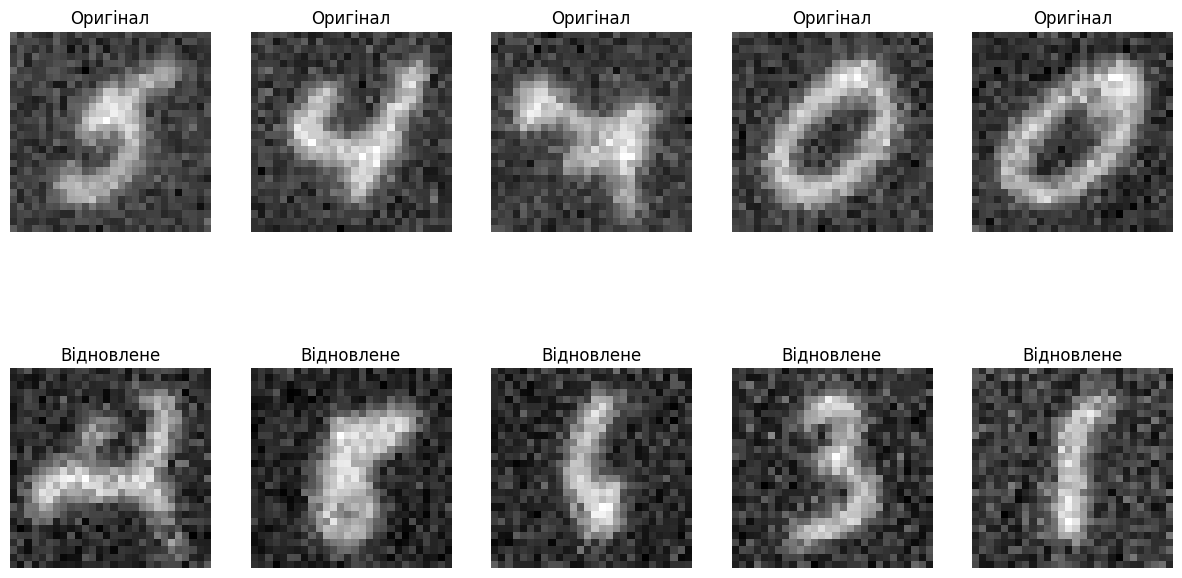

Epoch [17/50] Batch 0/938 Loss D: 1.3230, Loss G: 0.8331
Epoch [17/50] Batch 100/938 Loss D: 1.1117, Loss G: 1.1090
Epoch [17/50] Batch 200/938 Loss D: 1.1576, Loss G: 1.1335
Epoch [17/50] Batch 300/938 Loss D: 1.3227, Loss G: 1.0470
Epoch [17/50] Batch 400/938 Loss D: 1.2123, Loss G: 1.5050
Epoch [17/50] Batch 500/938 Loss D: 1.1675, Loss G: 1.6195
Epoch [17/50] Batch 600/938 Loss D: 1.0009, Loss G: 1.1971
Epoch [17/50] Batch 700/938 Loss D: 1.0230, Loss G: 1.3476
Epoch [17/50] Batch 800/938 Loss D: 1.1006, Loss G: 1.1547
Epoch [17/50] Batch 900/938 Loss D: 1.1571, Loss G: 1.5709


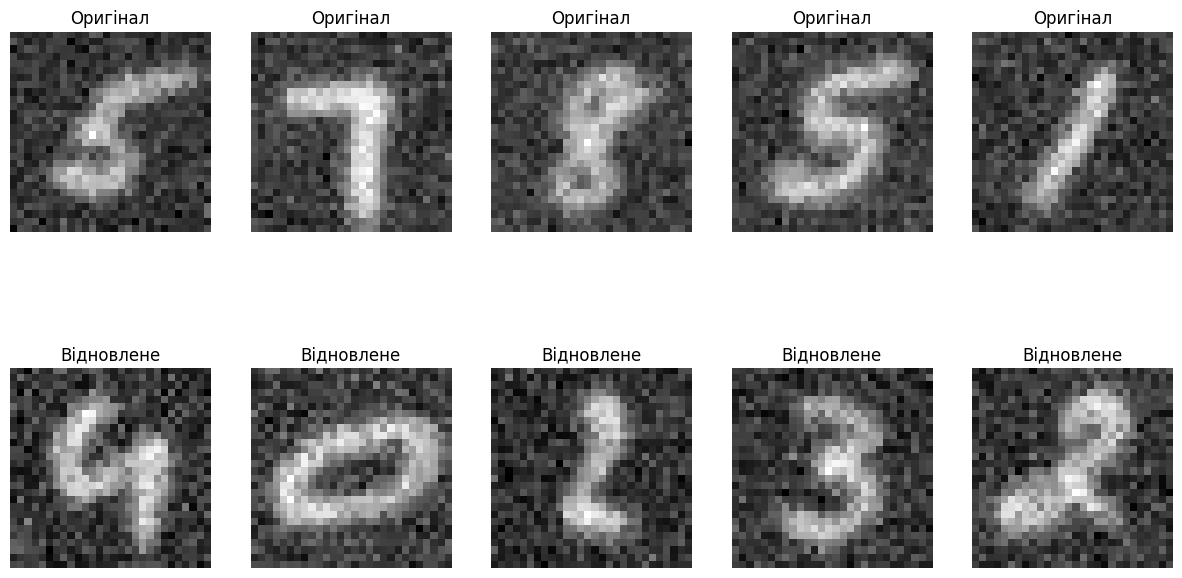

Epoch [18/50] Batch 0/938 Loss D: 1.3070, Loss G: 0.9441
Epoch [18/50] Batch 100/938 Loss D: 0.9648, Loss G: 1.3235
Epoch [18/50] Batch 200/938 Loss D: 1.1291, Loss G: 1.7666
Epoch [18/50] Batch 300/938 Loss D: 1.2678, Loss G: 1.0959
Epoch [18/50] Batch 400/938 Loss D: 1.2009, Loss G: 1.0581
Epoch [18/50] Batch 500/938 Loss D: 0.9976, Loss G: 1.8140
Epoch [18/50] Batch 600/938 Loss D: 1.2113, Loss G: 1.4950
Epoch [18/50] Batch 700/938 Loss D: 1.1839, Loss G: 0.8097
Epoch [18/50] Batch 800/938 Loss D: 1.0403, Loss G: 1.3282
Epoch [18/50] Batch 900/938 Loss D: 1.3040, Loss G: 1.6421


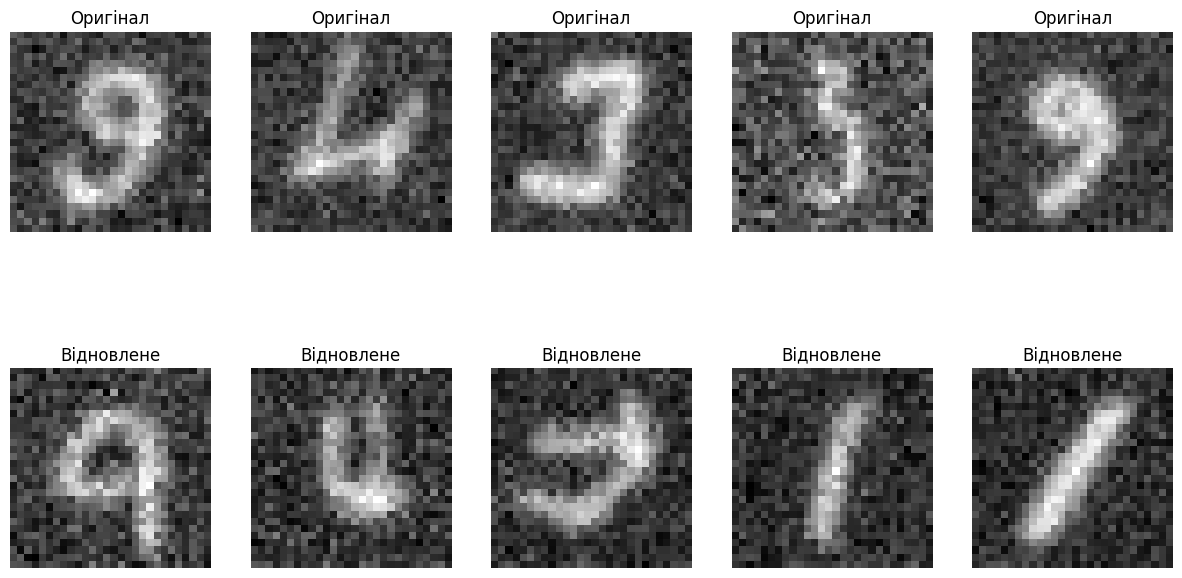

Epoch [19/50] Batch 0/938 Loss D: 1.1783, Loss G: 1.2045
Epoch [19/50] Batch 100/938 Loss D: 1.1054, Loss G: 1.3654
Epoch [19/50] Batch 200/938 Loss D: 0.9751, Loss G: 1.4806
Epoch [19/50] Batch 300/938 Loss D: 1.3658, Loss G: 1.0577
Epoch [19/50] Batch 400/938 Loss D: 1.1168, Loss G: 1.0167
Epoch [19/50] Batch 500/938 Loss D: 1.1570, Loss G: 1.1642
Epoch [19/50] Batch 600/938 Loss D: 1.2035, Loss G: 1.3442
Epoch [19/50] Batch 700/938 Loss D: 1.0395, Loss G: 1.5225
Epoch [19/50] Batch 800/938 Loss D: 0.9186, Loss G: 1.6140
Epoch [19/50] Batch 900/938 Loss D: 1.1830, Loss G: 1.1383


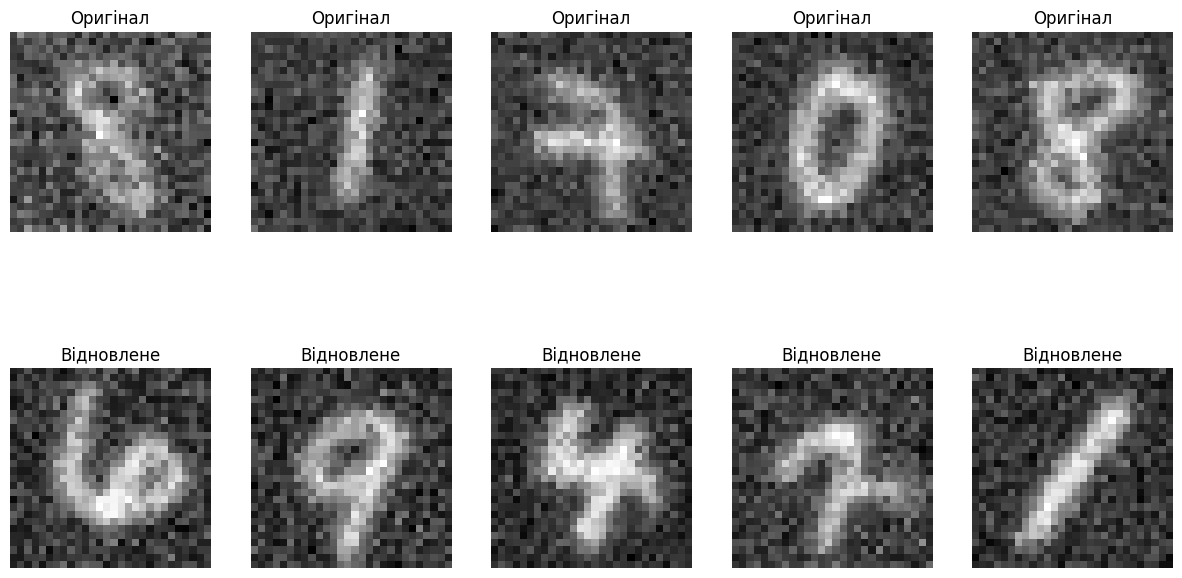

Epoch [20/50] Batch 0/938 Loss D: 1.0213, Loss G: 1.3752
Epoch [20/50] Batch 100/938 Loss D: 1.2183, Loss G: 1.1160
Epoch [20/50] Batch 200/938 Loss D: 0.9997, Loss G: 1.8608
Epoch [20/50] Batch 300/938 Loss D: 0.9918, Loss G: 1.2627
Epoch [20/50] Batch 400/938 Loss D: 1.0559, Loss G: 1.2693
Epoch [20/50] Batch 500/938 Loss D: 1.4697, Loss G: 1.7637
Epoch [20/50] Batch 600/938 Loss D: 0.8206, Loss G: 1.4294
Epoch [20/50] Batch 700/938 Loss D: 1.1577, Loss G: 1.5831
Epoch [20/50] Batch 800/938 Loss D: 1.1671, Loss G: 1.2224
Epoch [20/50] Batch 900/938 Loss D: 1.3617, Loss G: 1.2685


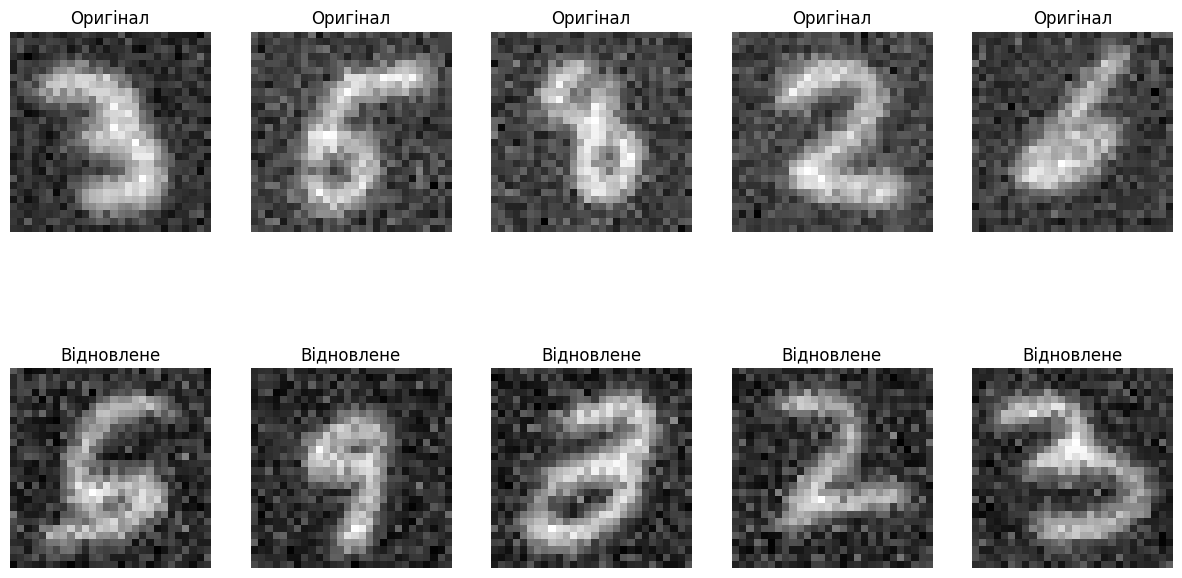

Epoch [21/50] Batch 0/938 Loss D: 1.1641, Loss G: 1.2022
Epoch [21/50] Batch 100/938 Loss D: 1.1326, Loss G: 1.1489
Epoch [21/50] Batch 200/938 Loss D: 1.1825, Loss G: 1.4330
Epoch [21/50] Batch 300/938 Loss D: 1.2081, Loss G: 1.0740
Epoch [21/50] Batch 400/938 Loss D: 0.9513, Loss G: 1.5205
Epoch [21/50] Batch 500/938 Loss D: 1.3048, Loss G: 1.4997
Epoch [21/50] Batch 600/938 Loss D: 1.1998, Loss G: 1.4231
Epoch [21/50] Batch 700/938 Loss D: 0.9561, Loss G: 1.4885
Epoch [21/50] Batch 800/938 Loss D: 1.2994, Loss G: 1.2335
Epoch [21/50] Batch 900/938 Loss D: 1.1290, Loss G: 1.2407


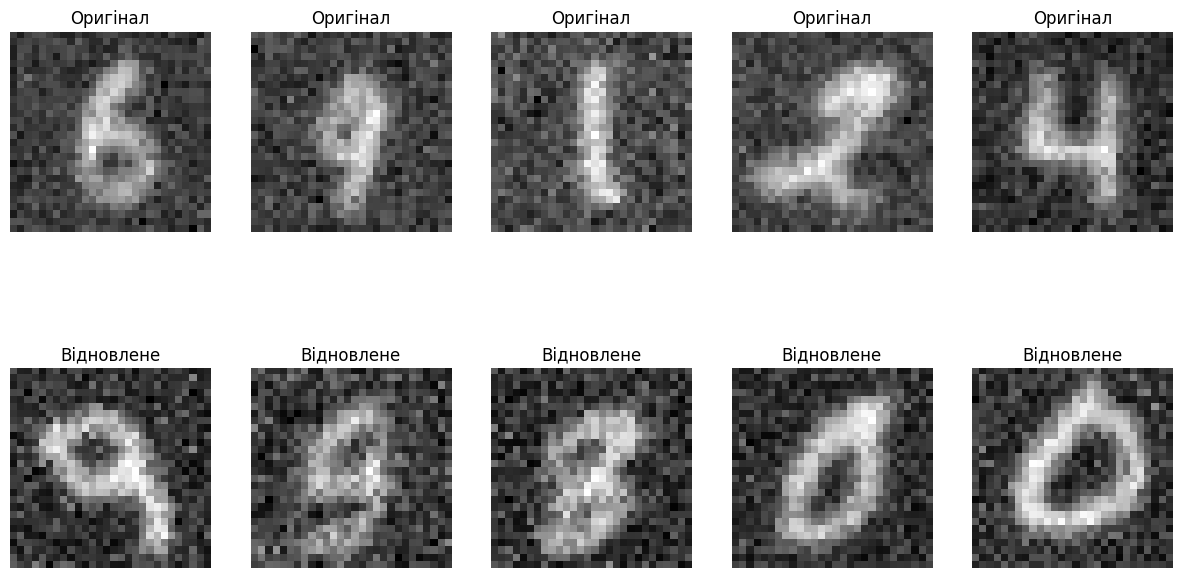

Epoch [22/50] Batch 0/938 Loss D: 1.1100, Loss G: 1.3782
Epoch [22/50] Batch 100/938 Loss D: 0.8913, Loss G: 1.6357
Epoch [22/50] Batch 200/938 Loss D: 0.9880, Loss G: 1.4788
Epoch [22/50] Batch 300/938 Loss D: 0.9617, Loss G: 1.5050
Epoch [22/50] Batch 400/938 Loss D: 1.2650, Loss G: 0.8640
Epoch [22/50] Batch 500/938 Loss D: 1.1962, Loss G: 1.3032
Epoch [22/50] Batch 600/938 Loss D: 1.0113, Loss G: 1.3612
Epoch [22/50] Batch 700/938 Loss D: 1.3322, Loss G: 1.0867
Epoch [22/50] Batch 800/938 Loss D: 0.9930, Loss G: 1.5442
Epoch [22/50] Batch 900/938 Loss D: 1.0398, Loss G: 1.3626


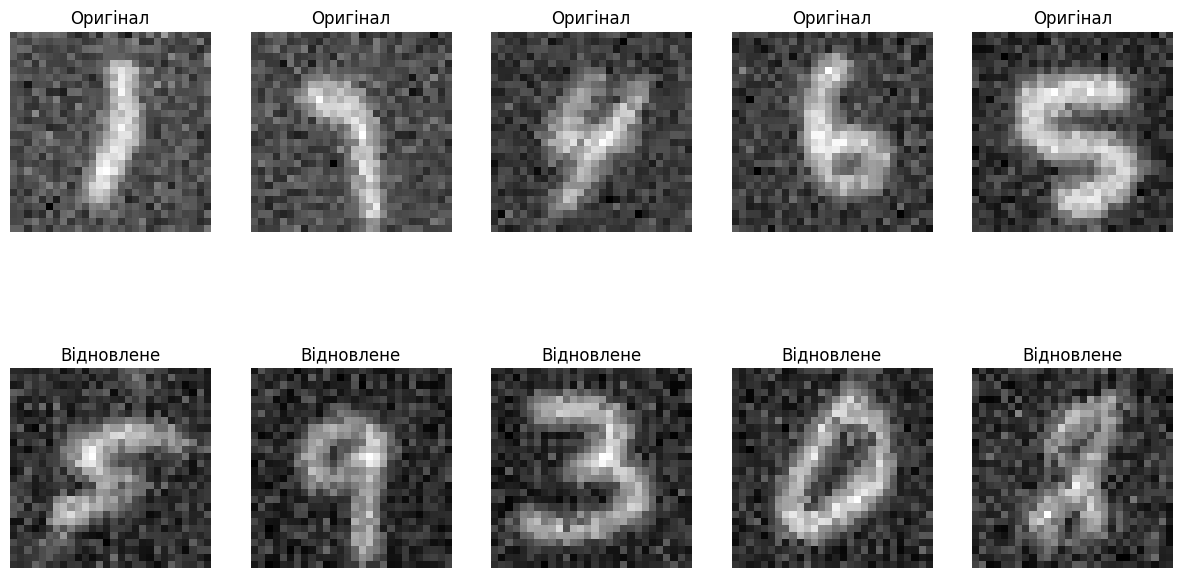

Epoch [23/50] Batch 0/938 Loss D: 1.0674, Loss G: 1.0792
Epoch [23/50] Batch 100/938 Loss D: 0.9679, Loss G: 1.1853
Epoch [23/50] Batch 200/938 Loss D: 1.1063, Loss G: 1.3893
Epoch [23/50] Batch 300/938 Loss D: 1.0383, Loss G: 1.3374
Epoch [23/50] Batch 400/938 Loss D: 1.0685, Loss G: 1.3003
Epoch [23/50] Batch 500/938 Loss D: 1.2054, Loss G: 1.1394
Epoch [23/50] Batch 600/938 Loss D: 1.2691, Loss G: 1.3559
Epoch [23/50] Batch 700/938 Loss D: 0.8764, Loss G: 1.3029
Epoch [23/50] Batch 800/938 Loss D: 1.4078, Loss G: 1.2943
Epoch [23/50] Batch 900/938 Loss D: 1.1821, Loss G: 1.3690


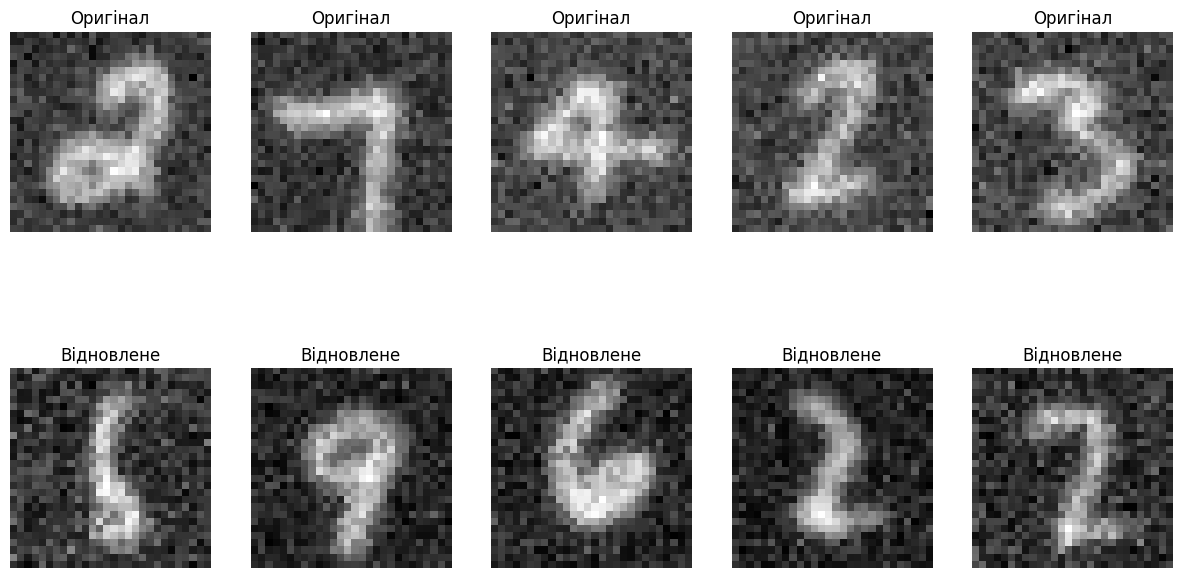

Epoch [24/50] Batch 0/938 Loss D: 1.1421, Loss G: 1.3001
Epoch [24/50] Batch 100/938 Loss D: 1.1014, Loss G: 1.0507
Epoch [24/50] Batch 200/938 Loss D: 0.9817, Loss G: 1.3272
Epoch [24/50] Batch 300/938 Loss D: 1.0605, Loss G: 1.3207
Epoch [24/50] Batch 400/938 Loss D: 1.1639, Loss G: 1.2016
Epoch [24/50] Batch 500/938 Loss D: 1.0392, Loss G: 1.4587
Epoch [24/50] Batch 600/938 Loss D: 1.2360, Loss G: 1.3482
Epoch [24/50] Batch 700/938 Loss D: 1.0764, Loss G: 1.2623
Epoch [24/50] Batch 800/938 Loss D: 1.1561, Loss G: 1.3288
Epoch [24/50] Batch 900/938 Loss D: 1.2841, Loss G: 1.1854


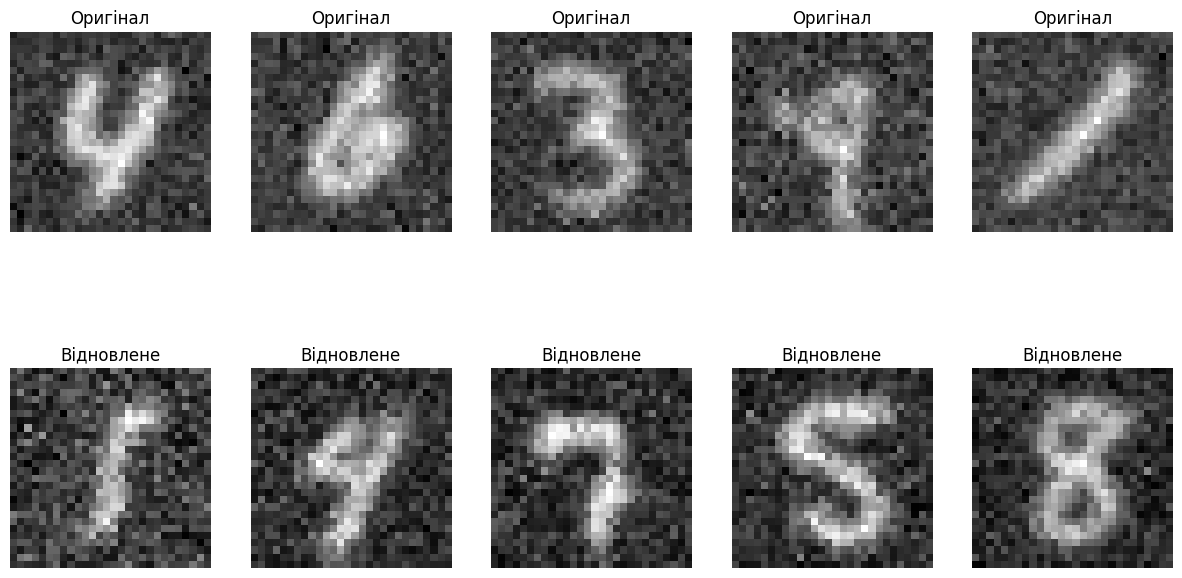

Epoch [25/50] Batch 0/938 Loss D: 1.1413, Loss G: 1.1287
Epoch [25/50] Batch 100/938 Loss D: 1.1282, Loss G: 1.1626
Epoch [25/50] Batch 200/938 Loss D: 1.1199, Loss G: 1.2739
Epoch [25/50] Batch 300/938 Loss D: 0.9879, Loss G: 1.0726
Epoch [25/50] Batch 400/938 Loss D: 0.9830, Loss G: 1.2309
Epoch [25/50] Batch 500/938 Loss D: 1.0383, Loss G: 2.0784
Epoch [25/50] Batch 600/938 Loss D: 1.2868, Loss G: 1.0462
Epoch [25/50] Batch 700/938 Loss D: 1.1180, Loss G: 1.6702
Epoch [25/50] Batch 800/938 Loss D: 1.1837, Loss G: 1.4171
Epoch [25/50] Batch 900/938 Loss D: 1.3883, Loss G: 1.2247


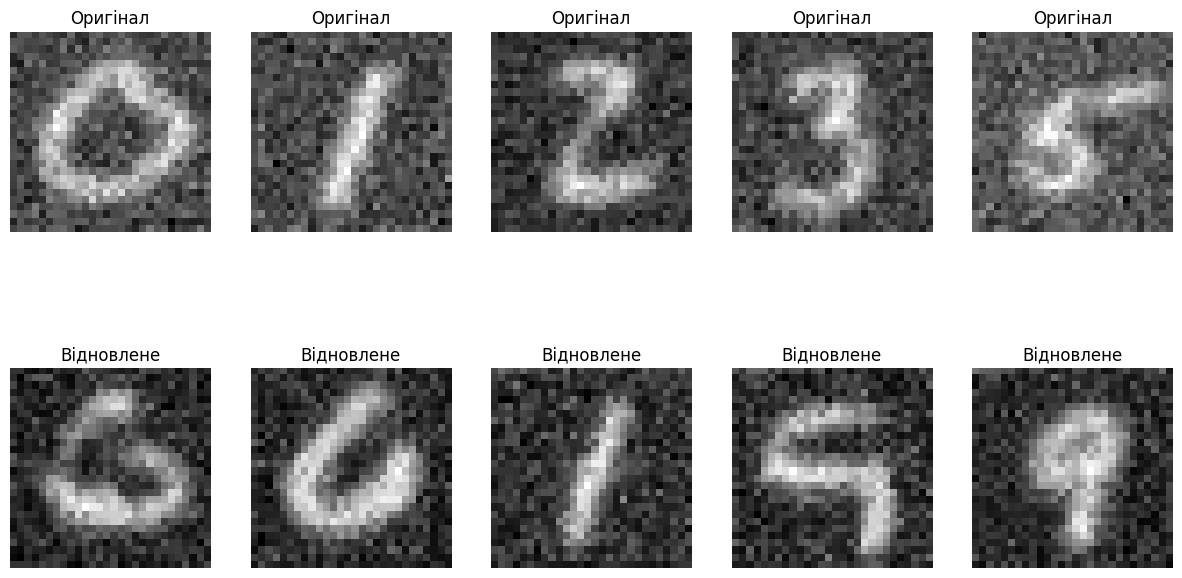

Epoch [26/50] Batch 0/938 Loss D: 1.0058, Loss G: 1.3356
Epoch [26/50] Batch 100/938 Loss D: 1.0850, Loss G: 1.3296
Epoch [26/50] Batch 200/938 Loss D: 1.1888, Loss G: 1.2085
Epoch [26/50] Batch 300/938 Loss D: 1.1759, Loss G: 1.4016
Epoch [26/50] Batch 400/938 Loss D: 1.0955, Loss G: 1.2851
Epoch [26/50] Batch 500/938 Loss D: 1.1790, Loss G: 1.3049
Epoch [26/50] Batch 600/938 Loss D: 1.3217, Loss G: 0.9151
Epoch [26/50] Batch 700/938 Loss D: 1.1024, Loss G: 1.9170
Epoch [26/50] Batch 800/938 Loss D: 1.0724, Loss G: 1.2411
Epoch [26/50] Batch 900/938 Loss D: 0.9167, Loss G: 1.6637


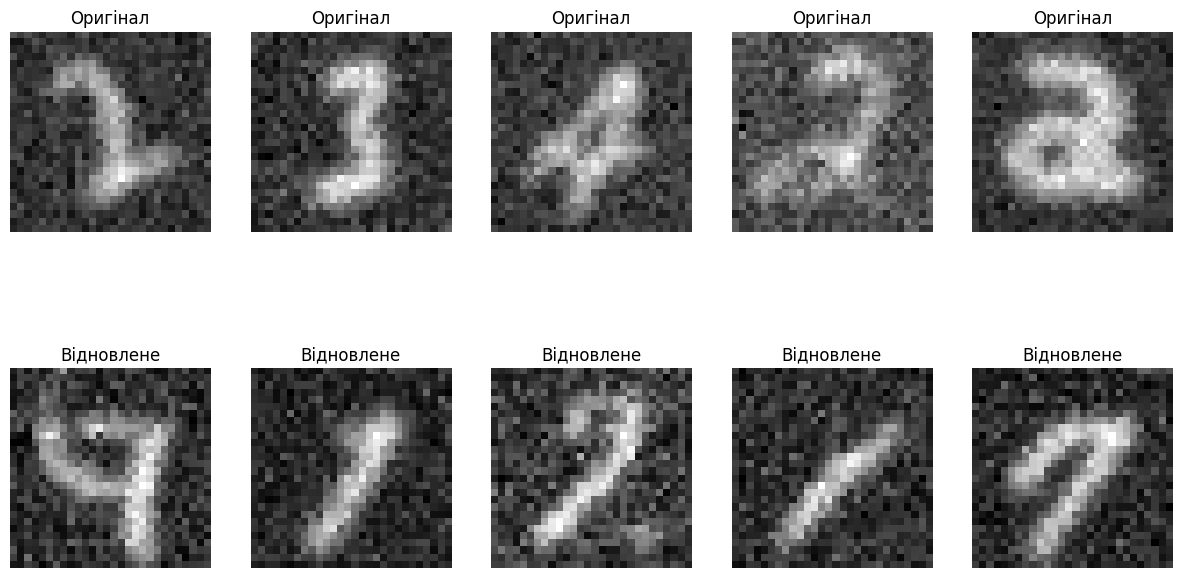

Epoch [27/50] Batch 0/938 Loss D: 1.2861, Loss G: 1.1907
Epoch [27/50] Batch 100/938 Loss D: 1.0422, Loss G: 1.5052
Epoch [27/50] Batch 200/938 Loss D: 1.2116, Loss G: 1.2700
Epoch [27/50] Batch 300/938 Loss D: 1.0800, Loss G: 1.4165
Epoch [27/50] Batch 400/938 Loss D: 1.1616, Loss G: 1.3202
Epoch [27/50] Batch 500/938 Loss D: 1.2131, Loss G: 1.0901
Epoch [27/50] Batch 600/938 Loss D: 1.0763, Loss G: 0.8481
Epoch [27/50] Batch 700/938 Loss D: 1.4251, Loss G: 0.6213
Epoch [27/50] Batch 800/938 Loss D: 1.2810, Loss G: 1.1386
Epoch [27/50] Batch 900/938 Loss D: 1.1240, Loss G: 1.6742


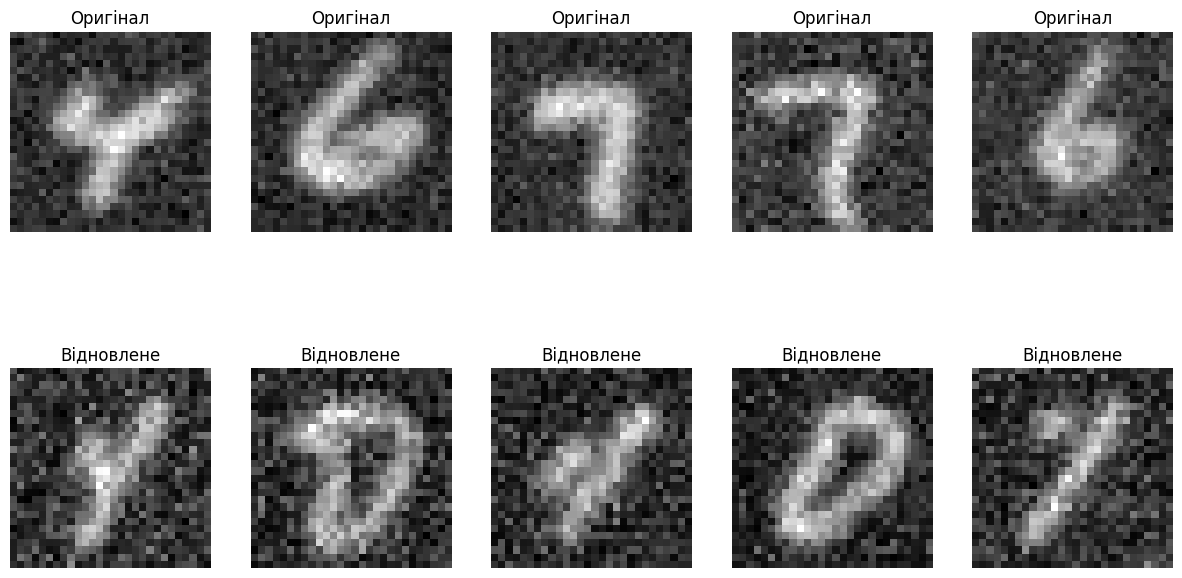

Epoch [28/50] Batch 0/938 Loss D: 1.3068, Loss G: 1.1826
Epoch [28/50] Batch 100/938 Loss D: 0.9734, Loss G: 1.2770
Epoch [28/50] Batch 200/938 Loss D: 1.1547, Loss G: 1.4005
Epoch [28/50] Batch 300/938 Loss D: 1.0010, Loss G: 1.5919
Epoch [28/50] Batch 400/938 Loss D: 1.1215, Loss G: 1.2363
Epoch [28/50] Batch 500/938 Loss D: 0.8651, Loss G: 1.1335
Epoch [28/50] Batch 600/938 Loss D: 1.2649, Loss G: 1.0816
Epoch [28/50] Batch 700/938 Loss D: 1.0130, Loss G: 1.4034
Epoch [28/50] Batch 800/938 Loss D: 1.3338, Loss G: 1.3909
Epoch [28/50] Batch 900/938 Loss D: 1.1917, Loss G: 1.3544


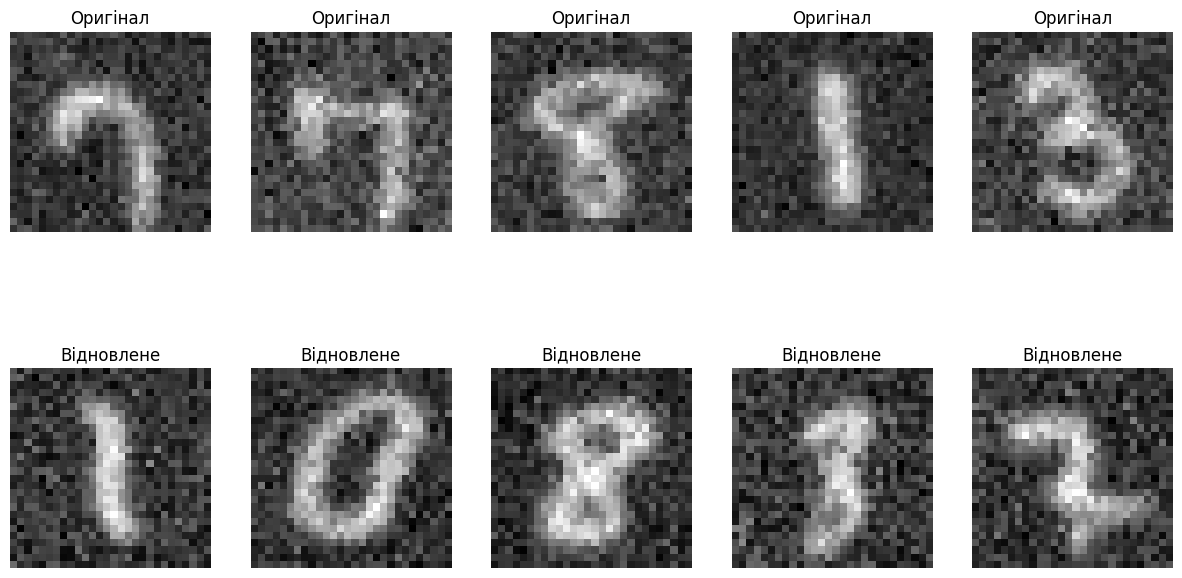

Epoch [29/50] Batch 0/938 Loss D: 0.9020, Loss G: 1.3609
Epoch [29/50] Batch 100/938 Loss D: 1.0536, Loss G: 1.3983
Epoch [29/50] Batch 200/938 Loss D: 1.1715, Loss G: 1.1841
Epoch [29/50] Batch 300/938 Loss D: 0.9440, Loss G: 1.5127
Epoch [29/50] Batch 400/938 Loss D: 1.2284, Loss G: 1.4706
Epoch [29/50] Batch 500/938 Loss D: 1.0825, Loss G: 1.3338
Epoch [29/50] Batch 600/938 Loss D: 1.3071, Loss G: 1.5229
Epoch [29/50] Batch 700/938 Loss D: 1.2325, Loss G: 0.5575
Epoch [29/50] Batch 800/938 Loss D: 1.0369, Loss G: 1.7811
Epoch [29/50] Batch 900/938 Loss D: 0.9190, Loss G: 1.5477


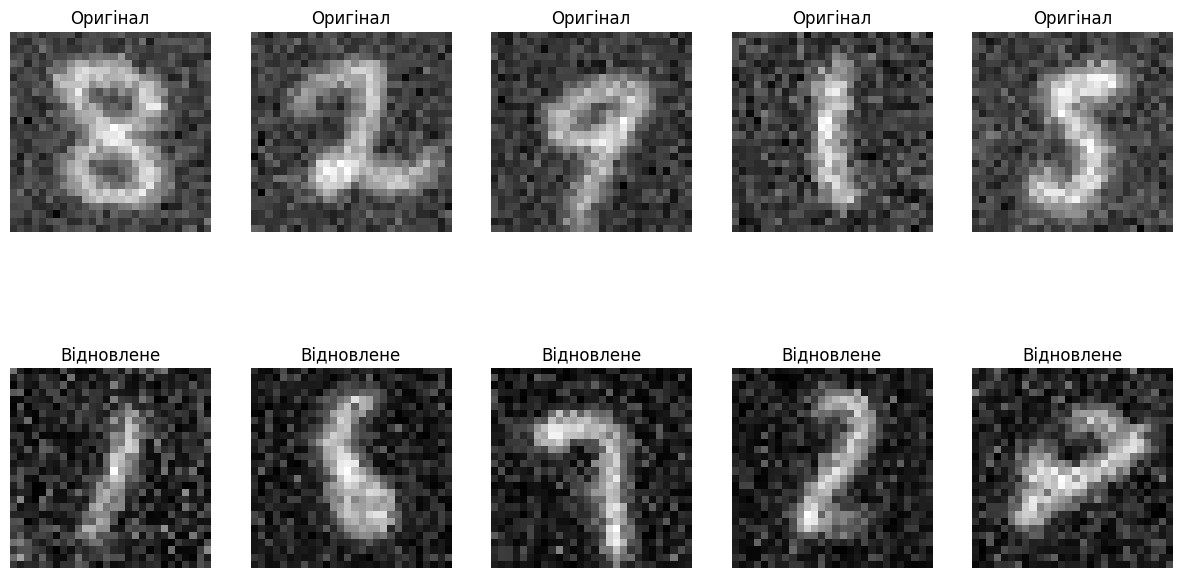

Epoch [30/50] Batch 0/938 Loss D: 1.1298, Loss G: 2.4598
Epoch [30/50] Batch 100/938 Loss D: 0.8642, Loss G: 1.6677
Epoch [30/50] Batch 200/938 Loss D: 0.9963, Loss G: 1.7173
Epoch [30/50] Batch 300/938 Loss D: 0.9138, Loss G: 1.1010
Epoch [30/50] Batch 400/938 Loss D: 1.2998, Loss G: 2.2405
Epoch [30/50] Batch 500/938 Loss D: 1.2786, Loss G: 0.4269
Epoch [30/50] Batch 600/938 Loss D: 1.0563, Loss G: 2.1805
Epoch [30/50] Batch 700/938 Loss D: 0.9150, Loss G: 1.4571
Epoch [30/50] Batch 800/938 Loss D: 0.9830, Loss G: 1.3591
Epoch [30/50] Batch 900/938 Loss D: 1.1416, Loss G: 1.3166


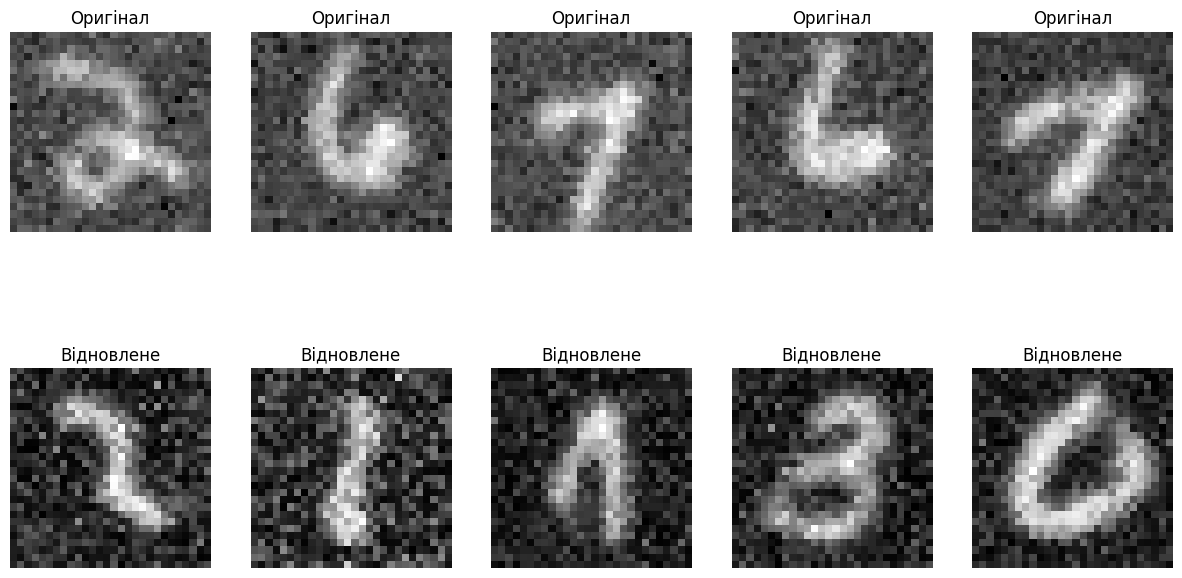

Epoch [31/50] Batch 0/938 Loss D: 0.9963, Loss G: 1.4530
Epoch [31/50] Batch 100/938 Loss D: 0.9615, Loss G: 1.2516
Epoch [31/50] Batch 200/938 Loss D: 0.9432, Loss G: 1.5747
Epoch [31/50] Batch 300/938 Loss D: 1.1437, Loss G: 0.6563
Epoch [31/50] Batch 400/938 Loss D: 1.2109, Loss G: 1.0361
Epoch [31/50] Batch 500/938 Loss D: 1.2081, Loss G: 1.3158
Epoch [31/50] Batch 600/938 Loss D: 0.9788, Loss G: 1.6376
Epoch [31/50] Batch 700/938 Loss D: 1.0617, Loss G: 1.4361
Epoch [31/50] Batch 800/938 Loss D: 1.4763, Loss G: 0.9682
Epoch [31/50] Batch 900/938 Loss D: 1.0400, Loss G: 1.2501


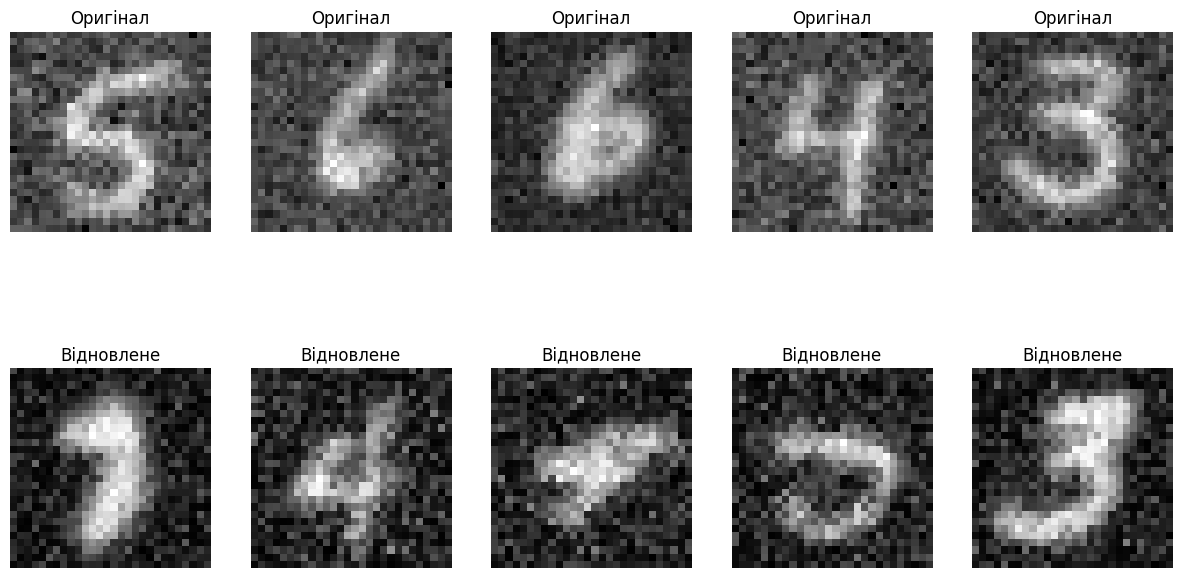

Epoch [32/50] Batch 0/938 Loss D: 1.4744, Loss G: 2.3760
Epoch [32/50] Batch 100/938 Loss D: 1.4577, Loss G: 0.7075
Epoch [32/50] Batch 200/938 Loss D: 0.9010, Loss G: 1.5373
Epoch [32/50] Batch 300/938 Loss D: 1.1239, Loss G: 2.0405
Epoch [32/50] Batch 400/938 Loss D: 0.8595, Loss G: 1.1820
Epoch [32/50] Batch 500/938 Loss D: 0.9251, Loss G: 1.1891
Epoch [32/50] Batch 600/938 Loss D: 0.8825, Loss G: 2.0283
Epoch [32/50] Batch 700/938 Loss D: 0.8580, Loss G: 1.6738
Epoch [32/50] Batch 800/938 Loss D: 0.9313, Loss G: 1.2077
Epoch [32/50] Batch 900/938 Loss D: 1.1140, Loss G: 1.1254


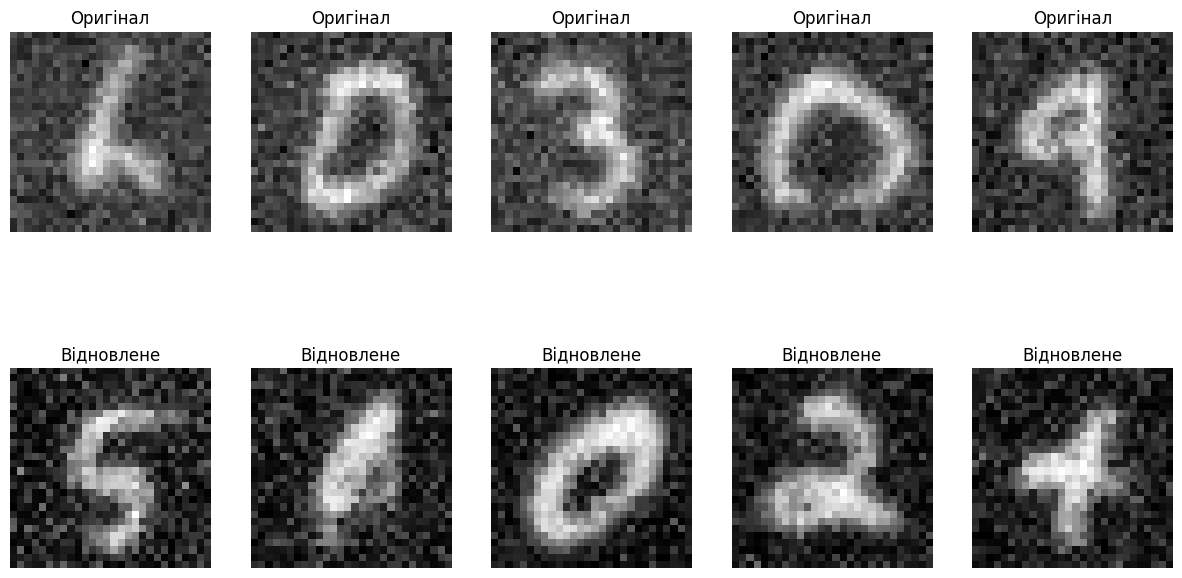

Epoch [33/50] Batch 0/938 Loss D: 1.0675, Loss G: 0.6729
Epoch [33/50] Batch 100/938 Loss D: 0.7794, Loss G: 1.5044
Epoch [33/50] Batch 200/938 Loss D: 0.9120, Loss G: 2.3511
Epoch [33/50] Batch 300/938 Loss D: 0.8486, Loss G: 2.0882
Epoch [33/50] Batch 400/938 Loss D: 1.0495, Loss G: 1.0336
Epoch [33/50] Batch 500/938 Loss D: 1.1785, Loss G: 0.6061
Epoch [33/50] Batch 600/938 Loss D: 0.9796, Loss G: 2.5526
Epoch [33/50] Batch 700/938 Loss D: 0.8463, Loss G: 1.9624
Epoch [33/50] Batch 800/938 Loss D: 1.0813, Loss G: 1.2437
Epoch [33/50] Batch 900/938 Loss D: 0.9015, Loss G: 2.1197


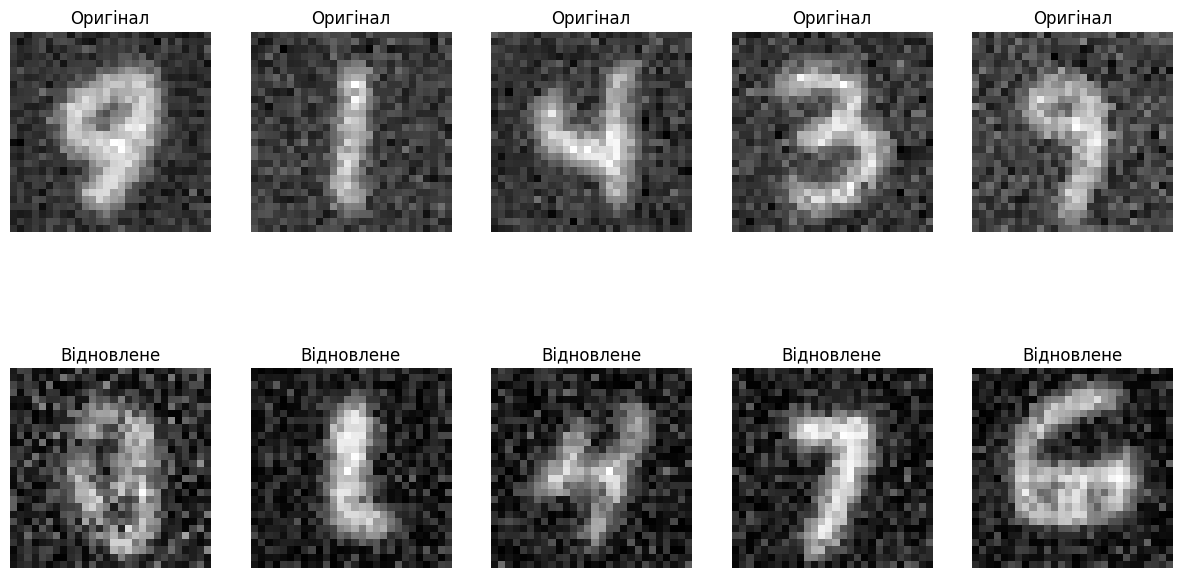

Epoch [34/50] Batch 0/938 Loss D: 0.9439, Loss G: 1.2253
Epoch [34/50] Batch 100/938 Loss D: 0.7384, Loss G: 1.0367
Epoch [34/50] Batch 200/938 Loss D: 0.8698, Loss G: 1.2763
Epoch [34/50] Batch 300/938 Loss D: 0.8046, Loss G: 1.7448
Epoch [34/50] Batch 400/938 Loss D: 0.7078, Loss G: 2.3138
Epoch [34/50] Batch 500/938 Loss D: 0.8864, Loss G: 1.5825
Epoch [34/50] Batch 600/938 Loss D: 0.8018, Loss G: 2.2760
Epoch [34/50] Batch 700/938 Loss D: 1.1552, Loss G: 1.1344
Epoch [34/50] Batch 800/938 Loss D: 0.7849, Loss G: 2.7726
Epoch [34/50] Batch 900/938 Loss D: 0.7974, Loss G: 2.4205


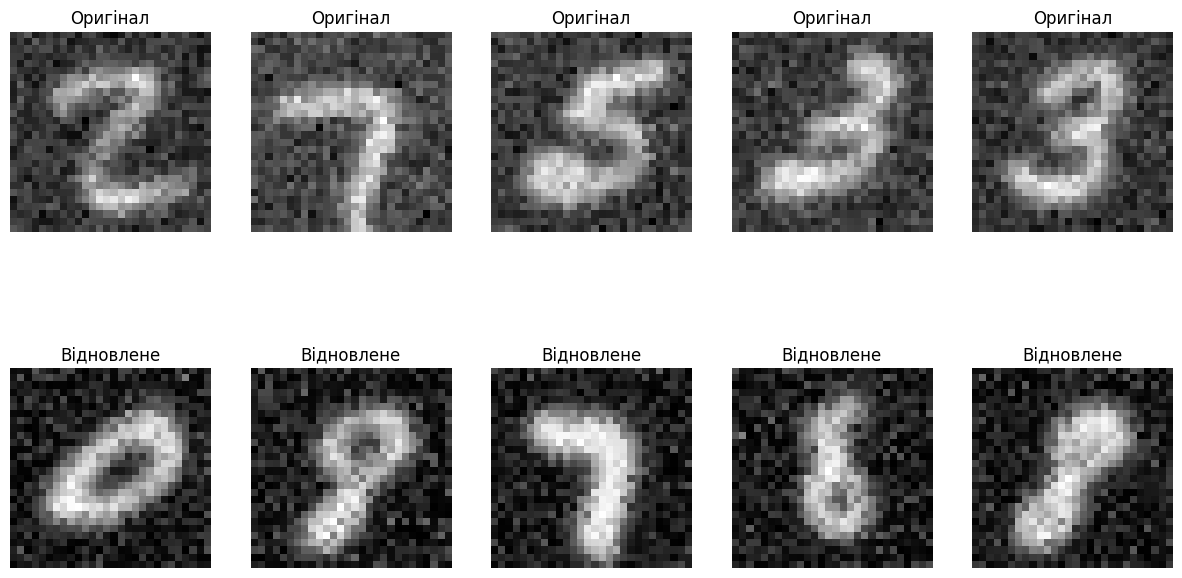

Epoch [35/50] Batch 0/938 Loss D: 0.9654, Loss G: 1.7408
Epoch [35/50] Batch 100/938 Loss D: 0.8692, Loss G: 2.4103
Epoch [35/50] Batch 200/938 Loss D: 0.7450, Loss G: 1.6947
Epoch [35/50] Batch 300/938 Loss D: 0.8408, Loss G: 2.6591
Epoch [35/50] Batch 400/938 Loss D: 0.7718, Loss G: 1.5957
Epoch [35/50] Batch 500/938 Loss D: 0.7426, Loss G: 1.3960
Epoch [35/50] Batch 600/938 Loss D: 0.9377, Loss G: 2.7733
Epoch [35/50] Batch 700/938 Loss D: 0.8502, Loss G: 1.9264
Epoch [35/50] Batch 800/938 Loss D: 0.9608, Loss G: 1.5479
Epoch [35/50] Batch 900/938 Loss D: 0.7851, Loss G: 1.4027


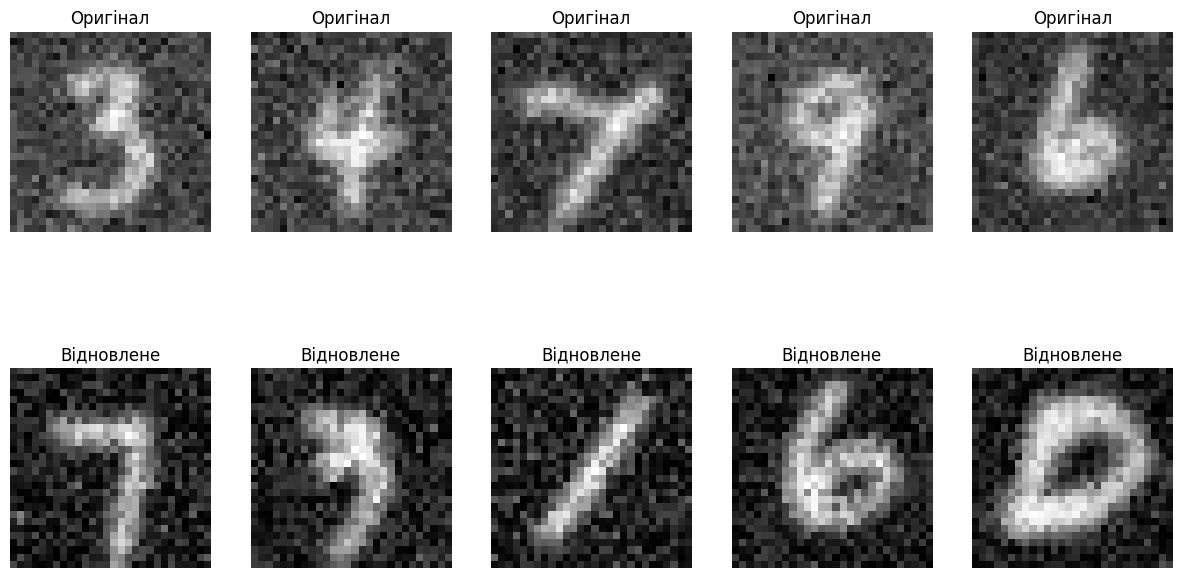

Epoch [36/50] Batch 0/938 Loss D: 0.8399, Loss G: 1.2446
Epoch [36/50] Batch 100/938 Loss D: 0.7101, Loss G: 2.6536
Epoch [36/50] Batch 200/938 Loss D: 0.5800, Loss G: 1.9173
Epoch [36/50] Batch 300/938 Loss D: 0.8516, Loss G: 1.3384
Epoch [36/50] Batch 400/938 Loss D: 0.7154, Loss G: 1.7250
Epoch [36/50] Batch 500/938 Loss D: 0.5490, Loss G: 1.9255
Epoch [36/50] Batch 600/938 Loss D: 1.0088, Loss G: 0.8657
Epoch [36/50] Batch 700/938 Loss D: 0.6852, Loss G: 1.8593
Epoch [36/50] Batch 800/938 Loss D: 0.7833, Loss G: 2.2356
Epoch [36/50] Batch 900/938 Loss D: 0.6068, Loss G: 2.1366


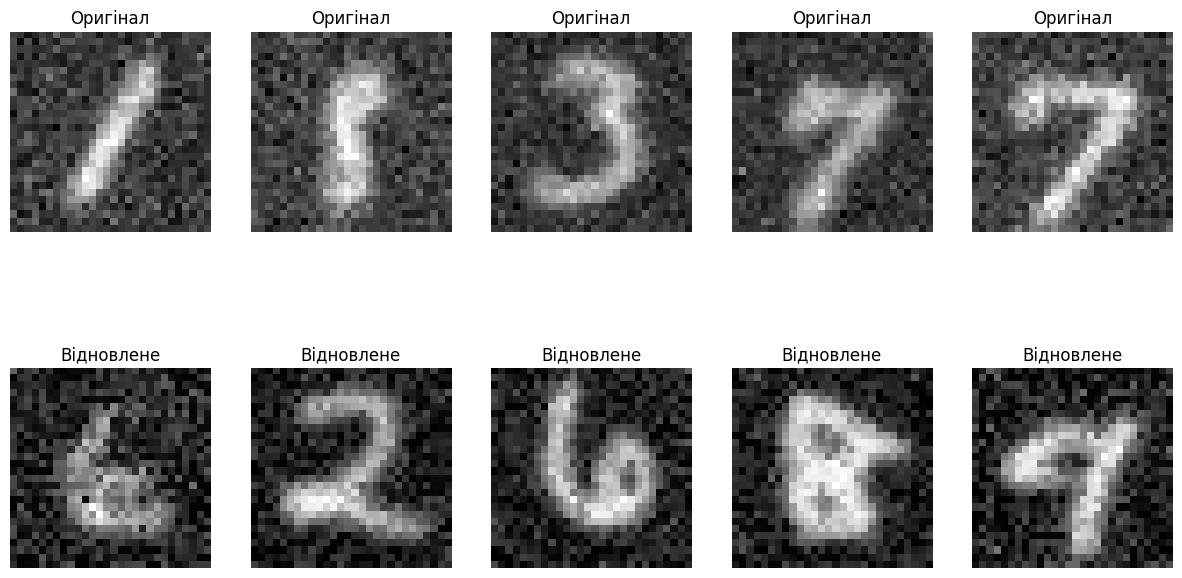

Epoch [37/50] Batch 0/938 Loss D: 0.6750, Loss G: 1.8562
Epoch [37/50] Batch 100/938 Loss D: 0.7780, Loss G: 1.1660
Epoch [37/50] Batch 200/938 Loss D: 0.7733, Loss G: 1.4764
Epoch [37/50] Batch 300/938 Loss D: 0.9095, Loss G: 2.0351
Epoch [37/50] Batch 400/938 Loss D: 0.5380, Loss G: 2.1643
Epoch [37/50] Batch 500/938 Loss D: 0.7224, Loss G: 2.6363
Epoch [37/50] Batch 600/938 Loss D: 0.5881, Loss G: 1.7644
Epoch [37/50] Batch 700/938 Loss D: 1.1456, Loss G: 2.2474
Epoch [37/50] Batch 800/938 Loss D: 0.6527, Loss G: 1.8186
Epoch [37/50] Batch 900/938 Loss D: 0.5087, Loss G: 3.3087


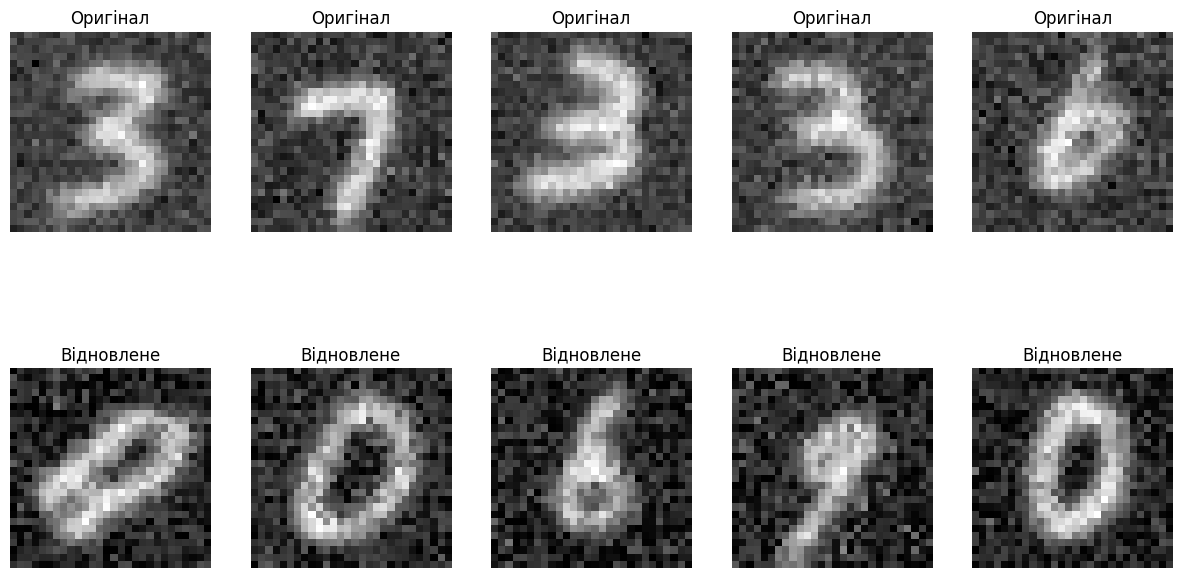

Epoch [38/50] Batch 0/938 Loss D: 0.8443, Loss G: 4.2444
Epoch [38/50] Batch 100/938 Loss D: 1.0779, Loss G: 3.4764
Epoch [38/50] Batch 200/938 Loss D: 0.6482, Loss G: 2.8744
Epoch [38/50] Batch 300/938 Loss D: 0.4830, Loss G: 2.9138
Epoch [38/50] Batch 400/938 Loss D: 1.2663, Loss G: 4.1911
Epoch [38/50] Batch 500/938 Loss D: 0.7570, Loss G: 3.4169
Epoch [38/50] Batch 600/938 Loss D: 1.1113, Loss G: 3.6897
Epoch [38/50] Batch 700/938 Loss D: 0.6079, Loss G: 3.1465
Epoch [38/50] Batch 800/938 Loss D: 0.5852, Loss G: 1.8483
Epoch [38/50] Batch 900/938 Loss D: 0.4925, Loss G: 3.2083


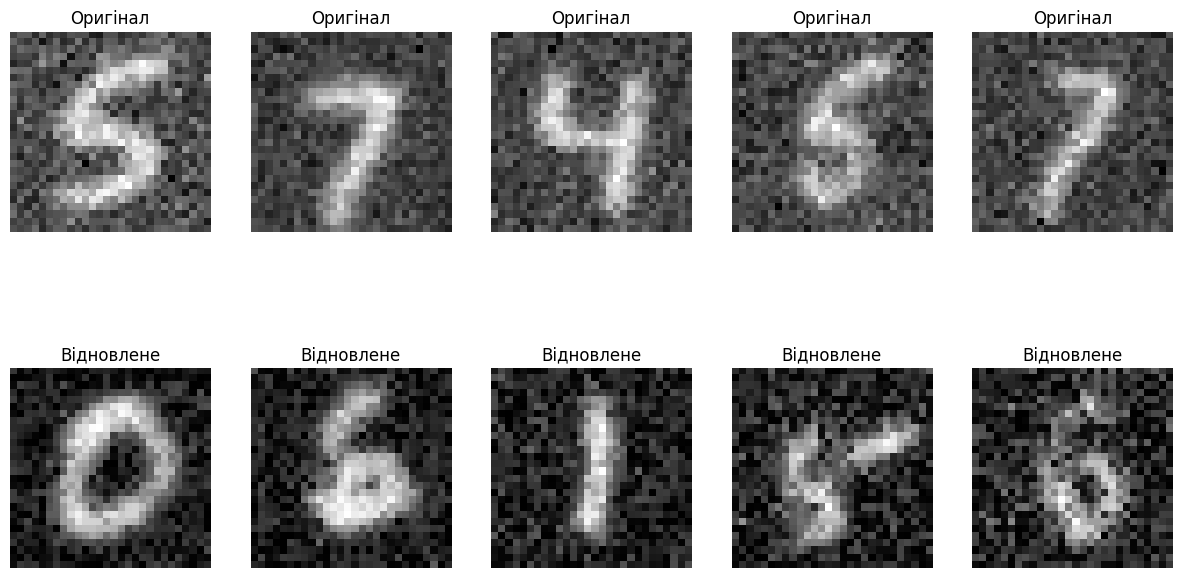

Epoch [39/50] Batch 0/938 Loss D: 0.7516, Loss G: 3.2086
Epoch [39/50] Batch 100/938 Loss D: 0.6233, Loss G: 2.7162
Epoch [39/50] Batch 200/938 Loss D: 0.6209, Loss G: 1.9266
Epoch [39/50] Batch 300/938 Loss D: 0.4458, Loss G: 3.2322
Epoch [39/50] Batch 400/938 Loss D: 0.7681, Loss G: 4.1086
Epoch [39/50] Batch 500/938 Loss D: 0.5097, Loss G: 2.6464
Epoch [39/50] Batch 600/938 Loss D: 0.4887, Loss G: 1.9693
Epoch [39/50] Batch 700/938 Loss D: 0.9358, Loss G: 1.7929
Epoch [39/50] Batch 800/938 Loss D: 1.0709, Loss G: 1.3591
Epoch [39/50] Batch 900/938 Loss D: 0.5061, Loss G: 3.1423


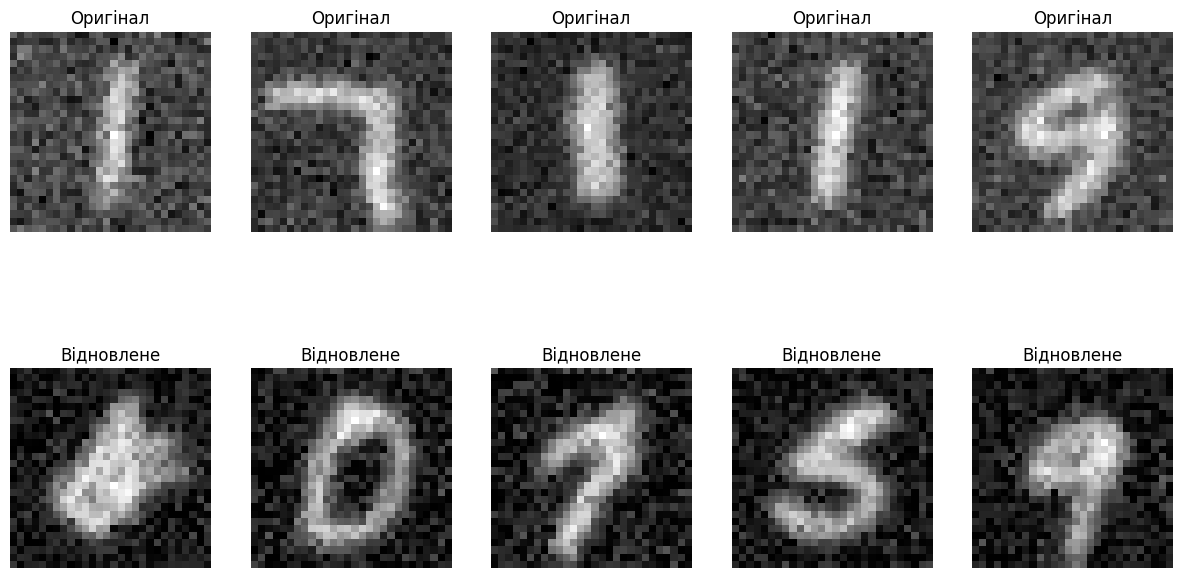

Epoch [40/50] Batch 0/938 Loss D: 0.6384, Loss G: 4.1995
Epoch [40/50] Batch 100/938 Loss D: 0.4763, Loss G: 1.9651
Epoch [40/50] Batch 200/938 Loss D: 0.4805, Loss G: 3.5300
Epoch [40/50] Batch 300/938 Loss D: 0.4807, Loss G: 2.0004
Epoch [40/50] Batch 400/938 Loss D: 0.3363, Loss G: 2.2213
Epoch [40/50] Batch 500/938 Loss D: 0.4053, Loss G: 2.2488
Epoch [40/50] Batch 600/938 Loss D: 0.3672, Loss G: 3.0755
Epoch [40/50] Batch 700/938 Loss D: 0.8690, Loss G: 5.0109
Epoch [40/50] Batch 800/938 Loss D: 0.3790, Loss G: 2.3407
Epoch [40/50] Batch 900/938 Loss D: 0.7452, Loss G: 4.0529


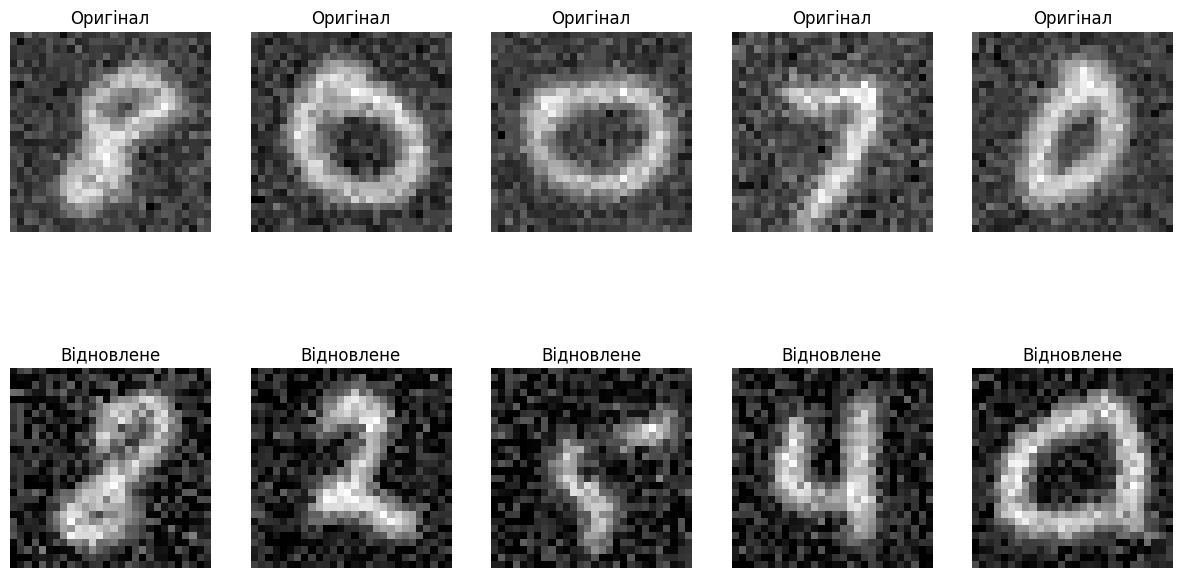

Epoch [41/50] Batch 0/938 Loss D: 0.8104, Loss G: 0.6088
Epoch [41/50] Batch 100/938 Loss D: 0.4515, Loss G: 1.5687
Epoch [41/50] Batch 200/938 Loss D: 0.3102, Loss G: 3.5011
Epoch [41/50] Batch 300/938 Loss D: 0.7758, Loss G: 4.4992
Epoch [41/50] Batch 400/938 Loss D: 0.4155, Loss G: 4.3859
Epoch [41/50] Batch 500/938 Loss D: 0.4282, Loss G: 2.6123
Epoch [41/50] Batch 600/938 Loss D: 0.4971, Loss G: 4.8111
Epoch [41/50] Batch 700/938 Loss D: 0.6996, Loss G: 1.0301
Epoch [41/50] Batch 800/938 Loss D: 0.6058, Loss G: 1.9612
Epoch [41/50] Batch 900/938 Loss D: 0.3454, Loss G: 2.5798


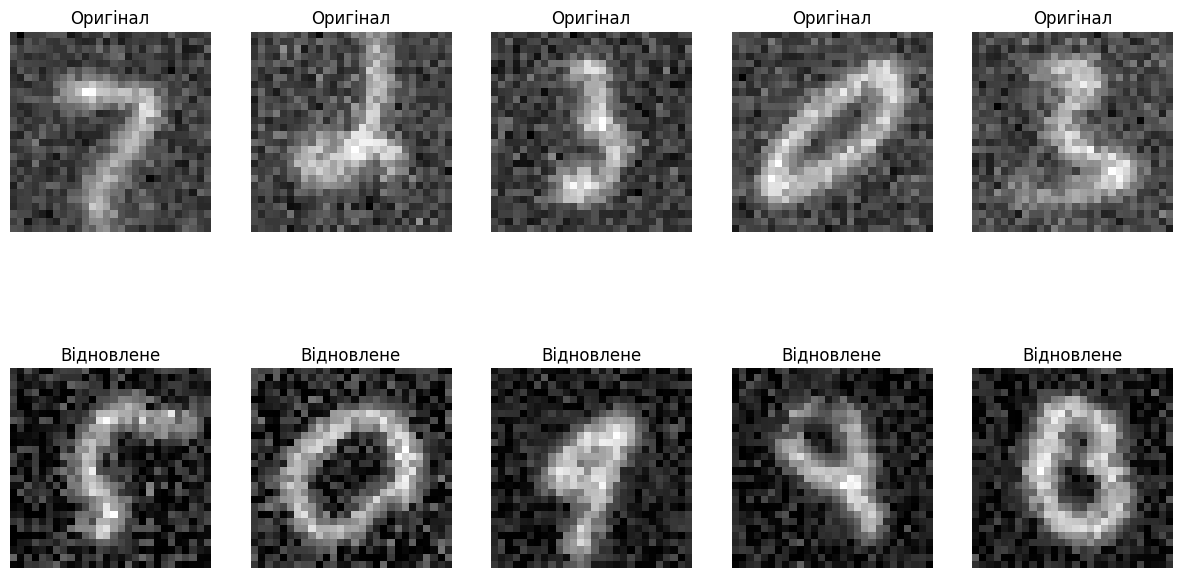

Epoch [42/50] Batch 0/938 Loss D: 0.4337, Loss G: 3.7067
Epoch [42/50] Batch 100/938 Loss D: 0.2733, Loss G: 3.2322
Epoch [42/50] Batch 200/938 Loss D: 0.4208, Loss G: 1.9914
Epoch [42/50] Batch 300/938 Loss D: 0.3944, Loss G: 3.5616
Epoch [42/50] Batch 400/938 Loss D: 1.1211, Loss G: 1.0047
Epoch [42/50] Batch 500/938 Loss D: 0.3990, Loss G: 4.4139
Epoch [42/50] Batch 600/938 Loss D: 2.5052, Loss G: 1.6065
Epoch [42/50] Batch 700/938 Loss D: 0.4049, Loss G: 4.2147
Epoch [42/50] Batch 800/938 Loss D: 0.4007, Loss G: 5.1863
Epoch [42/50] Batch 900/938 Loss D: 0.2637, Loss G: 2.4045


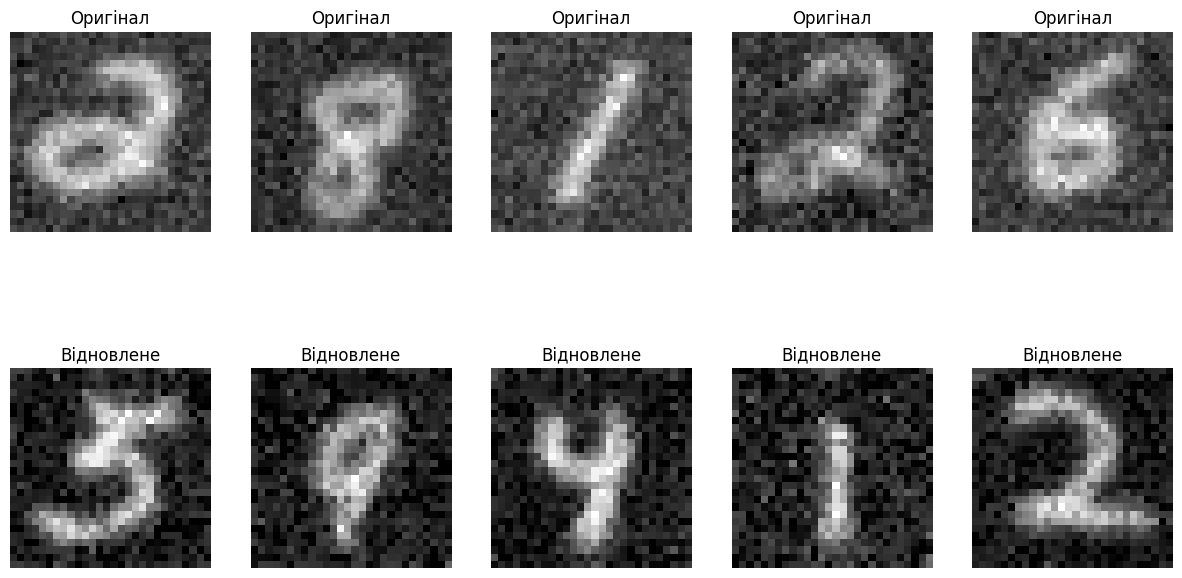

Epoch [43/50] Batch 0/938 Loss D: 0.4881, Loss G: 2.8761
Epoch [43/50] Batch 100/938 Loss D: 0.2594, Loss G: 3.4585
Epoch [43/50] Batch 200/938 Loss D: 0.4204, Loss G: 4.2680
Epoch [43/50] Batch 300/938 Loss D: 1.1344, Loss G: 6.0696
Epoch [43/50] Batch 400/938 Loss D: 0.8634, Loss G: 2.0575
Epoch [43/50] Batch 500/938 Loss D: 0.3468, Loss G: 3.3128
Epoch [43/50] Batch 600/938 Loss D: 0.1691, Loss G: 3.3424
Epoch [43/50] Batch 700/938 Loss D: 0.2294, Loss G: 3.6161
Epoch [43/50] Batch 800/938 Loss D: 0.4668, Loss G: 1.1181
Epoch [43/50] Batch 900/938 Loss D: 0.2505, Loss G: 2.4527


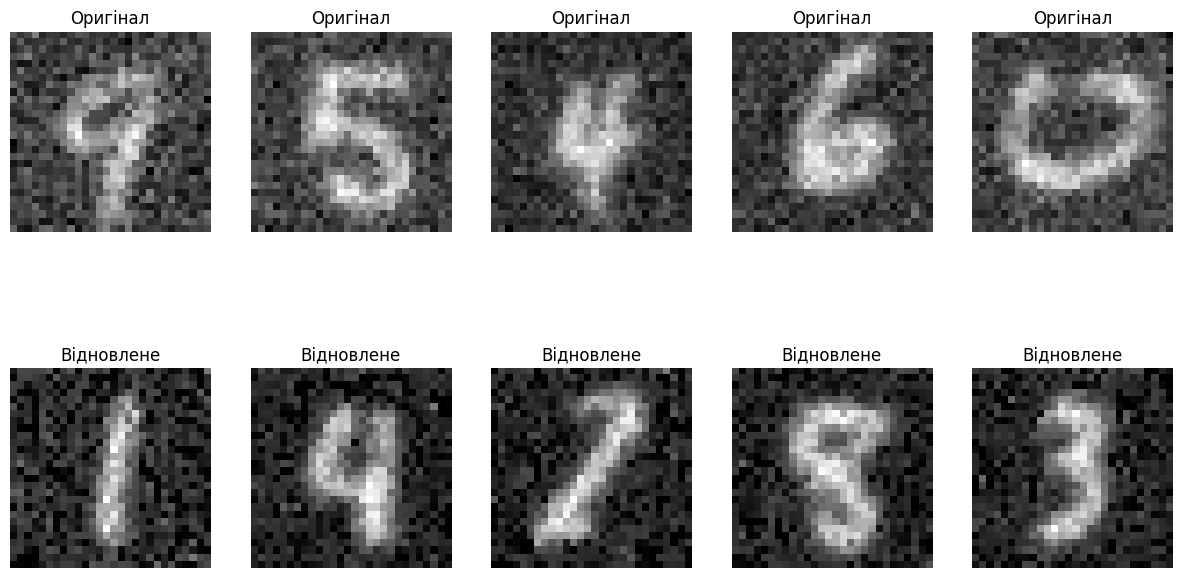

Epoch [44/50] Batch 0/938 Loss D: 0.2141, Loss G: 3.1241
Epoch [44/50] Batch 100/938 Loss D: 0.1534, Loss G: 4.0094
Epoch [44/50] Batch 200/938 Loss D: 0.1519, Loss G: 4.2524
Epoch [44/50] Batch 300/938 Loss D: 0.5226, Loss G: 4.4590
Epoch [44/50] Batch 400/938 Loss D: 0.2368, Loss G: 3.3019
Epoch [44/50] Batch 500/938 Loss D: 0.5027, Loss G: 1.9457
Epoch [44/50] Batch 600/938 Loss D: 0.5172, Loss G: 6.2346
Epoch [44/50] Batch 700/938 Loss D: 0.3067, Loss G: 3.2202
Epoch [44/50] Batch 800/938 Loss D: 0.2211, Loss G: 3.2376
Epoch [44/50] Batch 900/938 Loss D: 0.2594, Loss G: 4.1019


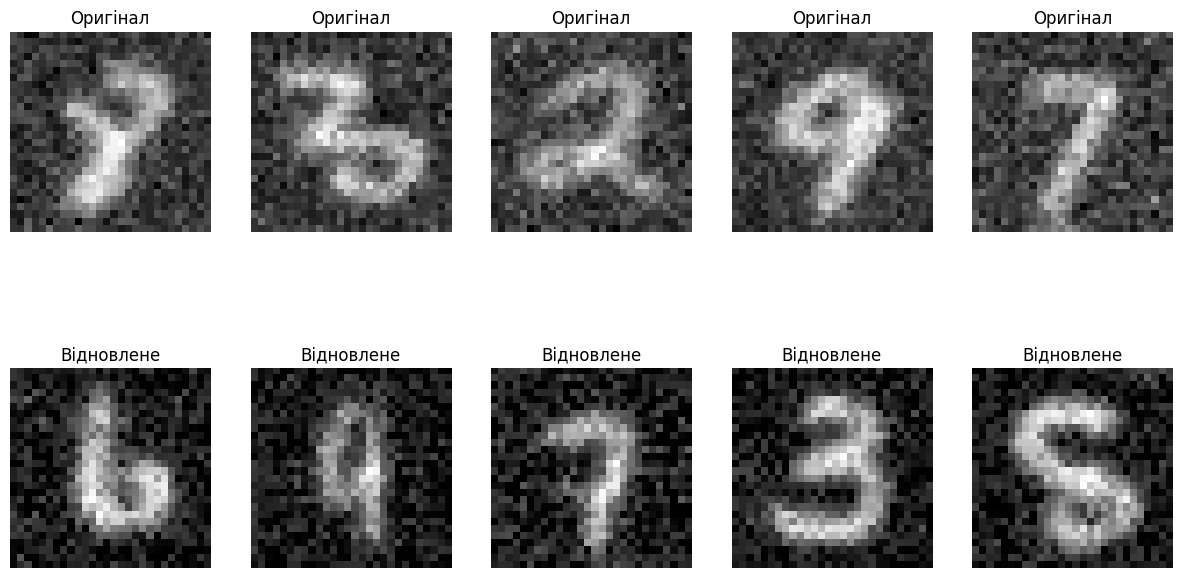

Epoch [45/50] Batch 0/938 Loss D: 0.4948, Loss G: 1.4780
Epoch [45/50] Batch 100/938 Loss D: 0.1474, Loss G: 3.9972
Epoch [45/50] Batch 200/938 Loss D: 0.2795, Loss G: 2.8452
Epoch [45/50] Batch 300/938 Loss D: 0.6451, Loss G: 5.1420
Epoch [45/50] Batch 400/938 Loss D: 0.2248, Loss G: 2.9433
Epoch [45/50] Batch 500/938 Loss D: 0.3106, Loss G: 6.8388
Epoch [45/50] Batch 600/938 Loss D: 0.4208, Loss G: 5.3982
Epoch [45/50] Batch 700/938 Loss D: 1.1722, Loss G: 3.8485
Epoch [45/50] Batch 800/938 Loss D: 0.4896, Loss G: 1.8534
Epoch [45/50] Batch 900/938 Loss D: 0.4663, Loss G: 3.2237


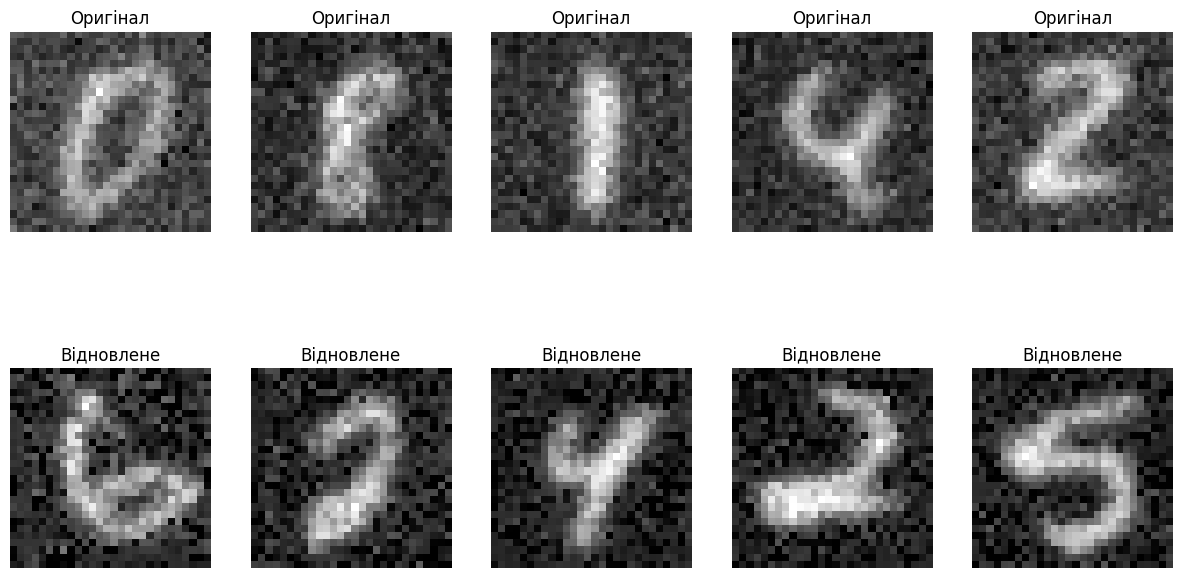

Epoch [46/50] Batch 0/938 Loss D: 0.4208, Loss G: 7.4344
Epoch [46/50] Batch 100/938 Loss D: 0.1478, Loss G: 3.8549
Epoch [46/50] Batch 200/938 Loss D: 0.2613, Loss G: 5.5363
Epoch [46/50] Batch 300/938 Loss D: 0.4894, Loss G: 1.7625
Epoch [46/50] Batch 400/938 Loss D: 0.1944, Loss G: 2.6083
Epoch [46/50] Batch 500/938 Loss D: 0.2199, Loss G: 4.9907
Epoch [46/50] Batch 600/938 Loss D: 0.2418, Loss G: 2.7245
Epoch [46/50] Batch 700/938 Loss D: 0.1784, Loss G: 4.2046
Epoch [46/50] Batch 800/938 Loss D: 0.3265, Loss G: 3.3629
Epoch [46/50] Batch 900/938 Loss D: 0.2252, Loss G: 3.0811


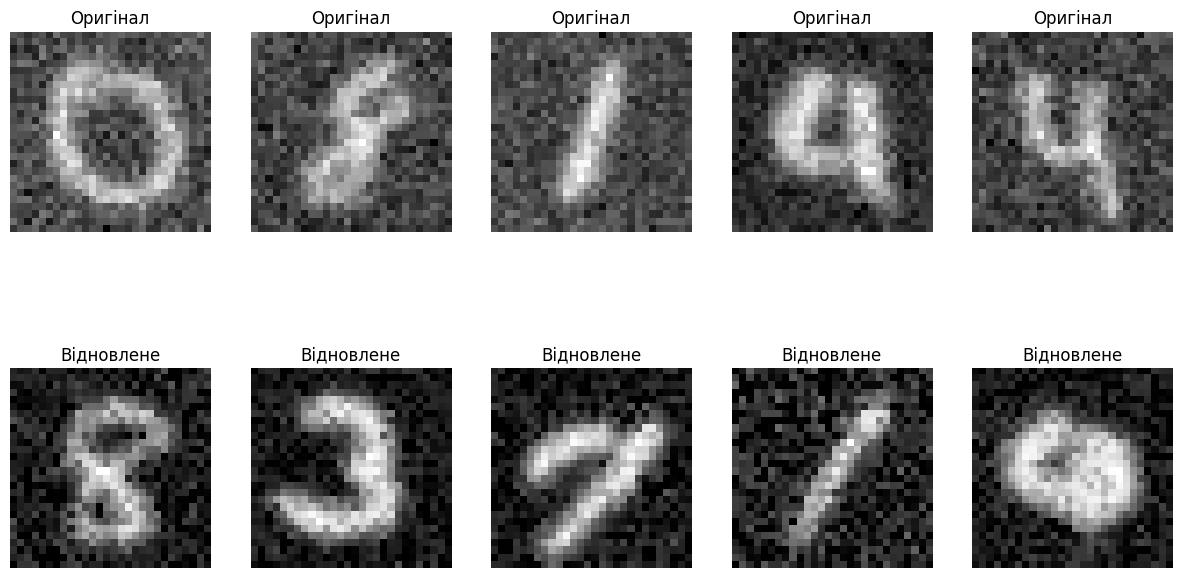

Epoch [47/50] Batch 0/938 Loss D: 0.6813, Loss G: 2.4801
Epoch [47/50] Batch 100/938 Loss D: 0.4391, Loss G: 3.4548
Epoch [47/50] Batch 200/938 Loss D: 0.2255, Loss G: 5.5682
Epoch [47/50] Batch 300/938 Loss D: 0.1841, Loss G: 2.8748
Epoch [47/50] Batch 400/938 Loss D: 5.2496, Loss G: 11.6218
Epoch [47/50] Batch 500/938 Loss D: 0.1807, Loss G: 4.5863
Epoch [47/50] Batch 600/938 Loss D: 0.3788, Loss G: 3.1995
Epoch [47/50] Batch 700/938 Loss D: 0.8713, Loss G: 2.5876
Epoch [47/50] Batch 800/938 Loss D: 0.1005, Loss G: 3.7189
Epoch [47/50] Batch 900/938 Loss D: 0.2837, Loss G: 5.4177


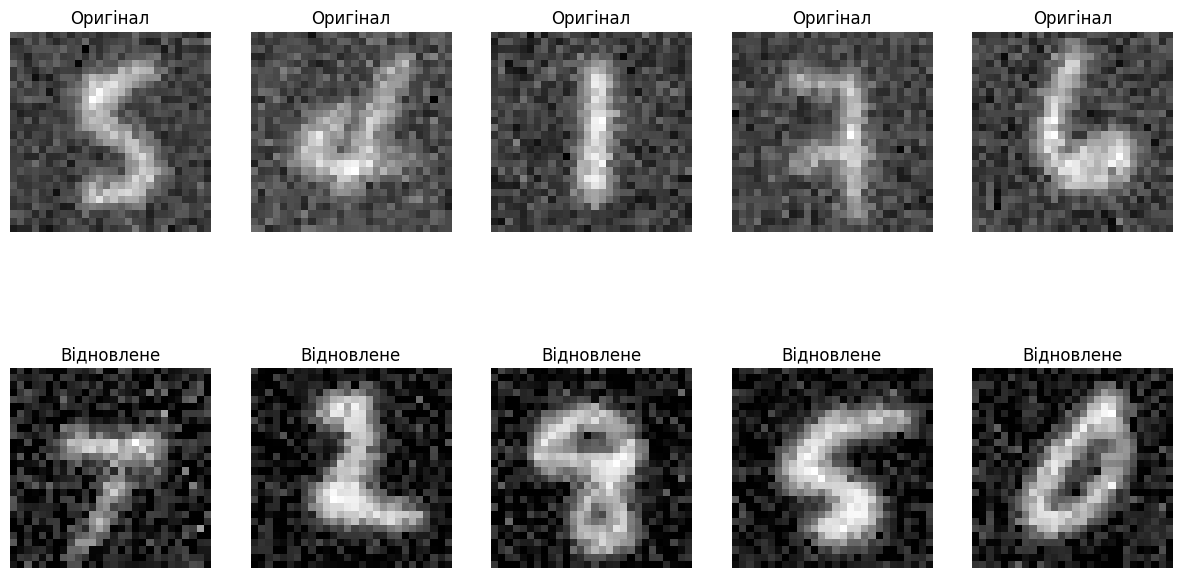

Epoch [48/50] Batch 0/938 Loss D: 0.0867, Loss G: 3.9510
Epoch [48/50] Batch 100/938 Loss D: 0.2389, Loss G: 4.4938
Epoch [48/50] Batch 200/938 Loss D: 0.3284, Loss G: 1.9588
Epoch [48/50] Batch 300/938 Loss D: 0.1133, Loss G: 4.0892
Epoch [48/50] Batch 400/938 Loss D: 0.1816, Loss G: 4.5797
Epoch [48/50] Batch 500/938 Loss D: 0.0730, Loss G: 4.9757
Epoch [48/50] Batch 600/938 Loss D: 0.1089, Loss G: 4.7233
Epoch [48/50] Batch 700/938 Loss D: 0.1927, Loss G: 3.4874
Epoch [48/50] Batch 800/938 Loss D: 0.1803, Loss G: 3.3401
Epoch [48/50] Batch 900/938 Loss D: 0.0701, Loss G: 4.0107


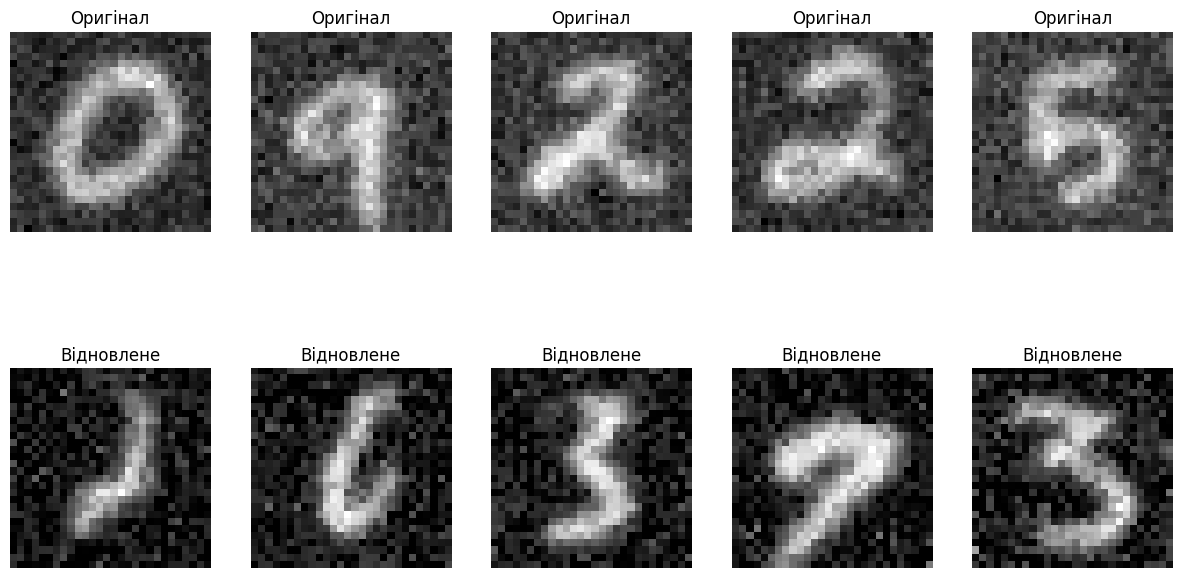

Epoch [49/50] Batch 0/938 Loss D: 0.0932, Loss G: 3.8427
Epoch [49/50] Batch 100/938 Loss D: 0.6062, Loss G: 4.9717
Epoch [49/50] Batch 200/938 Loss D: 0.1311, Loss G: 4.0892
Epoch [49/50] Batch 300/938 Loss D: 0.4874, Loss G: 1.1612
Epoch [49/50] Batch 400/938 Loss D: 0.1901, Loss G: 2.7931
Epoch [49/50] Batch 500/938 Loss D: 0.1287, Loss G: 4.6846
Epoch [49/50] Batch 600/938 Loss D: 0.0607, Loss G: 3.9961
Epoch [49/50] Batch 700/938 Loss D: 0.7362, Loss G: 1.5694
Epoch [49/50] Batch 800/938 Loss D: 0.3104, Loss G: 1.8514
Epoch [49/50] Batch 900/938 Loss D: 0.0991, Loss G: 4.2302


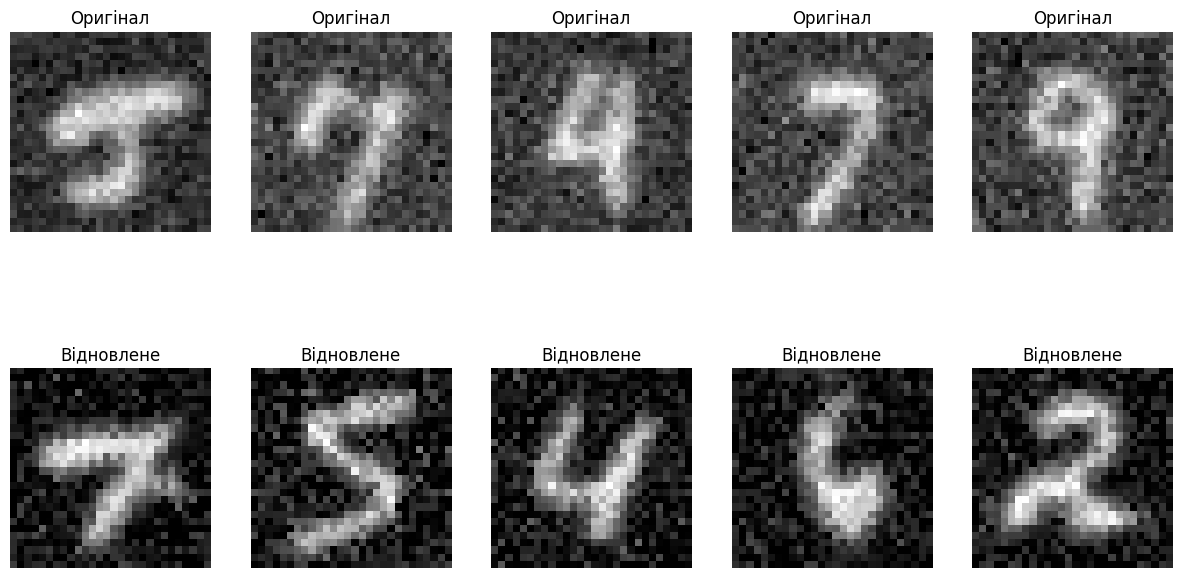

Epoch [50/50] Batch 0/938 Loss D: 0.1770, Loss G: 4.0937
Epoch [50/50] Batch 100/938 Loss D: 0.1988, Loss G: 4.1291
Epoch [50/50] Batch 200/938 Loss D: 0.0602, Loss G: 4.3476
Epoch [50/50] Batch 300/938 Loss D: 0.3037, Loss G: 2.8644
Epoch [50/50] Batch 400/938 Loss D: 0.1707, Loss G: 4.5212
Epoch [50/50] Batch 500/938 Loss D: 0.3458, Loss G: 3.5997
Epoch [50/50] Batch 600/938 Loss D: 0.1143, Loss G: 4.9197
Epoch [50/50] Batch 700/938 Loss D: 0.0991, Loss G: 3.8833
Epoch [50/50] Batch 800/938 Loss D: 0.2138, Loss G: 3.1676
Epoch [50/50] Batch 900/938 Loss D: 0.2039, Loss G: 3.0421


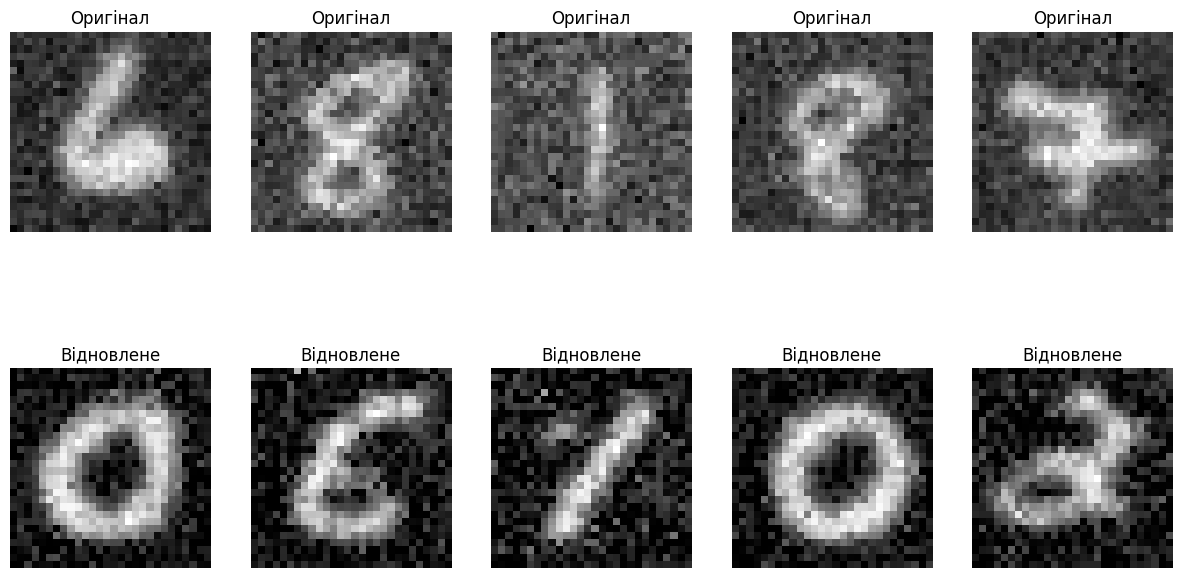

Навчання завершено.


In [11]:
# Цикл навчання
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        # Переміщення даних на GPU
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # --- Крок 1: Навчання дискримінатора ---
        optimizer_D.zero_grad()

        # Реальні зображення
        labels = torch.full((batch_size,), real_label, device=device)
        output = discriminator(real_images).view(-1)
        loss_real = adversarial_loss(output, labels)

        # Згенеровані зображення
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        labels = torch.full((batch_size,), fake_label, device=device)
        output = discriminator(fake_images.detach()).view(-1)
        loss_fake = adversarial_loss(output, labels)

        # Підсумкові втрати дискримінатора
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # --- Крок 2: Навчання генератора ---
        optimizer_G.zero_grad()
        labels.fill_(real_label)  # Генератор намагається "обдурити" дискримінатор
        output = discriminator(fake_images).view(-1)
        loss_G = adversarial_loss(output, labels)
        loss_G.backward()
        optimizer_G.step()

        # Вивід стану навчання
        if i % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}] Batch {i}/{len(train_loader)} "
                f"Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}"
            )

    # Виведення кількох зображень з шумом
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    for i in range(5):
        axes[0, i].imshow(real_images[i][0].cpu().numpy(), cmap="gray")
        axes[0, i].set_title("Оригінал")
        axes[0, i].axis("off")

        axes[1, i].imshow(fake_images[i][0].detach().cpu().numpy(), cmap="gray")
        axes[1, i].set_title("Відновлене")
        axes[1, i].axis("off")
    plt.show()

print("Навчання завершено.")

In [14]:
%pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 16.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 MB 57.2 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


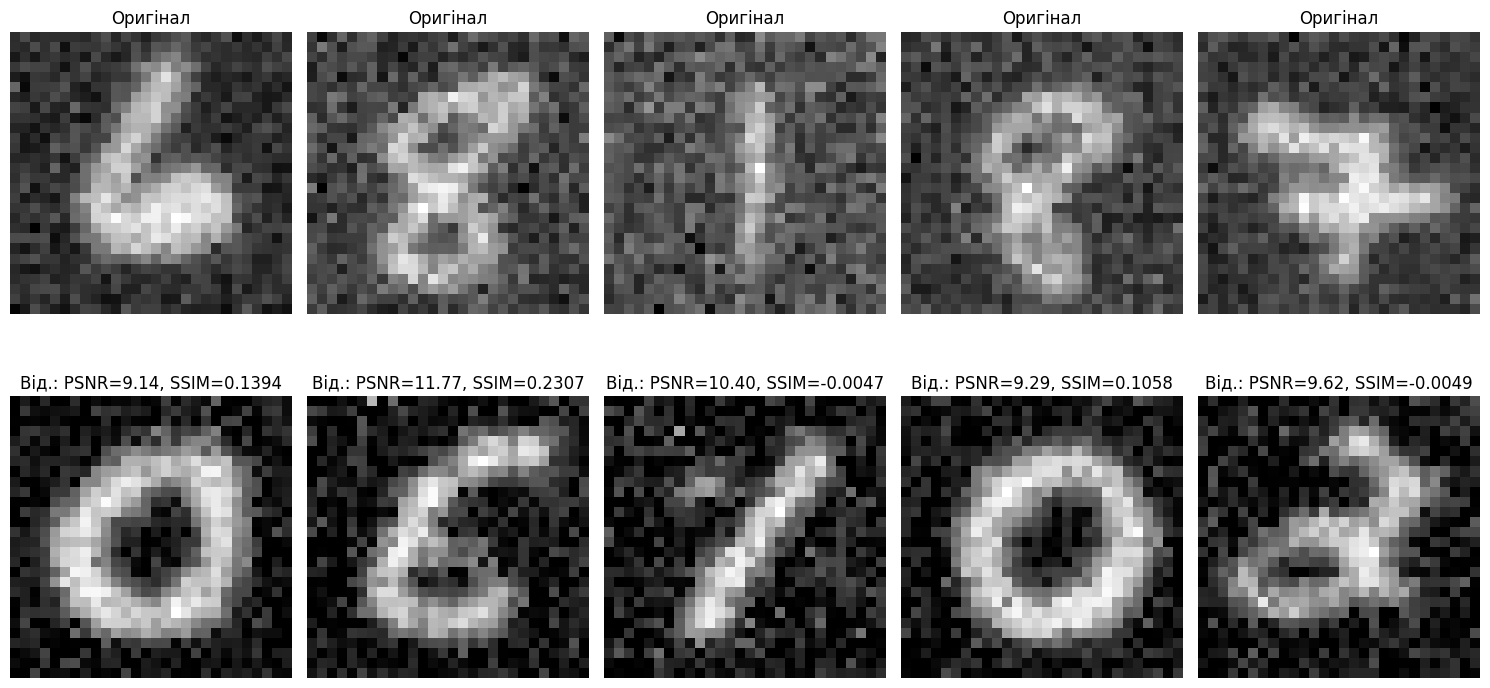

In [16]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Оцінка ефективності для одного прикладу
def evaluate_image_quality(original, generated):
    """
    Обчислює метрики PSNR і SSIM між оригінальним та відновленим зображеннями.
    :param original: Тензор оригінального зображення (1xHxW)
    :param generated: Тензор відновленого зображення (1xHxW)
    :return: PSNR і SSIM
    """
    # Перетворення тензорів у numpy та від'єднання від графу обчислень
    original = original.squeeze().detach().cpu().numpy()
    generated = generated.squeeze().detach().cpu().numpy()
    
    # Обчислення PSNR і SSIM
    psnr_value = psnr(original, generated, data_range=generated.max() - generated.min())
    ssim_value = ssim(original, generated, data_range=generated.max() - generated.min())
    
    return psnr_value, ssim_value

# Візуалізація результатів з метриками
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
for i in range(5):
    original_image = real_images[i][0]
    generated_image = fake_images[i][0]

    psnr_val, ssim_val = evaluate_image_quality(original_image, generated_image)
    
    # Відображення оригінальних зображень
    axes[0, i].imshow(original_image.detach().cpu().numpy(), cmap="gray")
    axes[0, i].set_title("Оригінал")
    axes[0, i].axis("off")

    # Відображення відновлених зображень
    axes[1, i].imshow(generated_image.detach().cpu().numpy(), cmap="gray")
    axes[1, i].set_title(f"Від.: PSNR={psnr_val:.2f}, SSIM={ssim_val:.4f}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # or (32, 32), etc.
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### 1. **Оптимізація генератора**
   - Додаємо **ResNet-блоки** для покращення передачі деталей.
   - Використовуємо **PixelShuffle** для плавного збільшення роздільної здатності.


In [138]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels)
        )
        
    def forward(self, x):
        return x + self.block(x)

class OptimizedGenerator(nn.Module):
    def __init__(self, latent_dim=100, num_residual_blocks=8):  # Increased blocks
        super(OptimizedGenerator, self).__init__()
        
        # Initial projection and reshape - fixed dimensions
        self.initial = nn.Sequential(
            # Project latent vector to 4x4x256 initial feature map
            nn.Linear(latent_dim, 4 * 4 * 256),
            nn.BatchNorm1d(4 * 4 * 256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Main convolutional backbone
        self.main = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Residual blocks
        self.residuals = nn.Sequential(
            *[ResidualBlock(256) for _ in range(num_residual_blocks)],
            nn.Dropout2d(0.2)
        )
        
        # Progressive upsampling
        self.upsample = nn.Sequential(
            # First upsampling block: 4x4 -> 8x8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Second upsampling block: 8x8 -> 16x16
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Third upsampling block: 16x16 -> 32x32
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Final output layer
        self.final = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Input shape: (batch_size, latent_dim)
        batch_size = x.size(0)
        
        # Project and reshape
        x = self.initial(x)
        x = x.view(batch_size, 256, 4, 4)  # Reshape to (batch_size, 256, 4, 4)
        
        # Forward pass through the network
        x = self.main(x)
        x = self.residuals(x)
        x = self.upsample(x)
        return self.final(x)


In [139]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Calculate the input features for the linear layer
        # If your input image is 32x32, after 3 Conv layers with stride 2:
        # 32x32 -> 16x16 -> 8x8 -> 4x4
        # So the input to linear layer will be: 256 * 4 * 4
        
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),  # Changed from 3*3 to 4*4
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.main(x)

### 2. **Функції втрат**
   - Впроваджуємо **Perceptual Loss** з використанням попередньо натренованої моделі (VGG).
   - Поєднуємо з **L1 Loss** для точності пікселів.

In [140]:
from torchvision.models import vgg16
import torch.nn.functional as F

class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        # Використовуємо попередньо натреновану VGG
        vgg = vgg16(pretrained=True).features[:16].eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg

    def forward(self, generated, target):
        # Розширення до 3 каналів
        generated = generated.expand(-1, 3, -1, -1)
        target = target.expand(-1, 3, -1, -1)
        
        # Масштабування зображень до розміру 224x224
        generated = F.interpolate(generated, size=(224, 224), mode='bilinear', align_corners=False)
        target = F.interpolate(target, size=(224, 224), mode='bilinear', align_corners=False)
        
        # Обчислення особливостей VGG
        gen_features = self.vgg(generated)
        target_features = self.vgg(target)
        
        return F.mse_loss(gen_features, target_features)


In [141]:
import torch.nn.functional as F

# Функція для забезпечення однакового розміру
def match_size(original, generated):
    """
    Змінює розмір generated, щоб відповідати розміру original.
    :param original: Тензор оригінального зображення.
    :param generated: Тензор згенерованого зображення.
    :return: Згенероване зображення з таким самим розміром, як у оригінального.
    """
    _, _, h, w = original.shape
    return F.interpolate(generated, size=(h, w), mode='bilinear', align_corners=False)


In [142]:
from torch.optim.lr_scheduler import StepLR

latent_dim = 100
real_label = 1.0
fake_label = 0.0

# Ініціалізація генератора і дискримінатора
generator = OptimizedGenerator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

# Функції втрат
adversarial_loss = nn.BCELoss()
pixel_loss = nn.L1Loss()
perceptual_loss = PerceptualLoss().to(device)

# Оптимізатори
optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Scheduler для динамічної зміни learning rate
scheduler_G = StepLR(optimizer_G, step_size=10, gamma=0.5)
scheduler_D = StepLR(optimizer_D, step_size=10, gamma=0.5)

num_epochs = 10
batch_size = 32

In [146]:
# Combined generator loss function
def combined_generator_loss(fake_output, real_images, fake_images):
    # Adversarial loss
    adv_loss = adversarial_loss(fake_output, torch.ones_like(fake_output))
    
    # Perceptual loss
    perceptual_loss_value = perceptual_loss(fake_images, real_images)
    
    # Resize fake images to match real images size
    fake_images_resized = F.interpolate(fake_images, size=real_images.shape[2:], mode='bilinear', align_corners=False)
    
    # Pixel loss
    pixel_loss_value = pixel_loss(fake_images_resized, real_images)
    
    # Combined loss with adjusted weights
    return adv_loss + 0.3 * pixel_loss_value + 0.1 * perceptual_loss_value



In [147]:
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        # Move data to device
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # -----------------
        # Train Discriminator
        # -----------------
        optimizer_D.zero_grad()
        
        # Real images
        label_real = torch.full((batch_size,), real_label, device=device)
        output_real = discriminator(real_images).view(-1)
        d_loss_real = adversarial_loss(output_real, label_real)

        # Fake images
        noise = torch.randn(batch_size, latent_dim, device=device)
        fake_images = generator(noise)
        label_fake = torch.full((batch_size,), fake_label, device=device)
        output_fake = discriminator(fake_images.detach()).view(-1)
        d_loss_fake = adversarial_loss(output_fake, label_fake)

        # Total discriminator loss
        d_loss = (d_loss_real + d_loss_fake) * 0.5
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()
        
        # Try to fool the discriminator
        output_fake = discriminator(fake_images).view(-1)
        g_loss = combined_generator_loss(output_fake, real_images, fake_images)
        g_loss.backward()
        optimizer_G.step()

        # Print progress
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], "
                  f"D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")
    
    # Step the learning rate schedulers
    scheduler_G.step()
    scheduler_D.step()

    # Visualization at the end of each epoch
    with torch.no_grad():
        # Generate sample images
        test_noise = torch.randn(5, latent_dim, device=device)
        generated_images = generator(test_noise)
        
        # Plot results
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        for j in range(5):
            # Plot real images
            axes[0, j].imshow(real_images[j].cpu().squeeze(), cmap='gray')
            axes[0, j].axis('off')
            axes[0, j].set_title('Real')
            
            # Plot fake images
            axes[1, j].imshow(generated_images[j].cpu().squeeze(), cmap='gray')
            axes[1, j].axis('off')
            axes[1, j].set_title('Generated')
        
        plt.tight_layout()
        plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x2304 and 4096x1)